# PA005: High Value Customer Identification (Insiders)

## 0.0. Planejamento da Solução (IOT)


### Input - Entrada

1. Problema de Negócio
    * Selecionar os clientes mais valioses para integrar um programa de Fidelização
2. Conjunto de Dados
    * Vendas de um e-commerce online, dutante o período de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: 
| client_id | is_insider |
|-----------|------------|
|    10323   |   yes/1    |
|    32413   |   no/1    |

2. Relatório com as perguntas de negócio
    * Quem são as pessoas elegíveis para participar do programa de Insiders?
    * Quantos clientes farão parte do grupo?
    * Quais as principais características desses clientes?
    * Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    * Qual a expectativa de faturamento desse grupo para os próximos meses?
    * Quais as condições para uma pessoa ser elegível ao Insiders?
    * Quais as condições para uma pessoa ser removida do Insiders?
    * Qual a garantia que o programa Insiders é melhor que o restante da base?
    * Quais ações o time de marketing pode realizar para aumentar o faturamento?

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio.
        - Alto LTV.
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência de compra:
        - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders

3. Quais as principais características desses clientes?
    - Escrever características do cliente:
        - Idade
        - Localização
    - Escrever características do consumo:
        - Atributos da clusterização

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano
    - Faturamento do grupo Insiders

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade (1 mês, 3 meses )
    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo.

7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a peirodicidade (1 mês, 3 meses )
    - A pessoa precisa ser desimilar ou não-parecida com uma pessoa do grupo.

8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses.

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">0.0. Imports</p></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import inflection
import umap.umap_        as umap
import re

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from plotly     import express as px
from IPython.display import HTML

from sklearn          import cluster as c
from sklearn          import metrics as mt
from sklearn          import ensemble as en
from sklearn          import preprocessing as pp
from sklearn          import decomposition as dd
from sklearn          import mixture as mx
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy as hc


from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings( 'ignore' )

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

C:\Users\Luan\anaconda3\envs\pa005cluster\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Luan\anaconda3\envs\pa005cluster\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Luan\anaconda3\envs\pa005cluster\Lib\site-packages\umap\distances.py:

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

## 0.2. Load Dataset

In [3]:
# load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1 )


In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39     17850.0  United Kingdom

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.0. Data Description</p></div>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

#rename
df1.columns = cols_new

In [8]:
df1.sample()

invoice_no stock_code          description  quantity invoice_date  unit_price  customer_id         country
275210     560938      21452  TOADSTOOL MONEY BOX         1    20-Jul-17        4.96          NaN  United Kingdom

## 1.2. Data dimensions

In [9]:
print( 'Número de Linhas: {}\nNúmero de Colunas: {}'.format(df1.shape[0], df1.shape[1]) )

Número de Linhas: 541909
Número de Colunas: 8


## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [18]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55  United Kingdom      17850.0
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39  United Kingdom      17850.0
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75  United Kingdom      17850.0
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39  United Kingdom      17850.0
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39  United Kingdom      17850.0

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

##  1.6 Change types

In [13]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [16]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median ) ).T

# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply(np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply(np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew()) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes       min      max      range          mean    median          std        skew       kurtosis
0     quantity -80995.00  80995.0  161990.00      9.552250      3.00   218.080957   -0.264076  119769.160031
1   unit_price -11062.06  38970.0   50032.06      4.611114      2.08    96.759764  186.506972   59005.719097
2  customer_id  12346.00  22709.0   10363.00  16688.840453  16249.00  2911.408666    0.487449      -0.804287

#### 1.7.1.1. Numerical Attributes - Investigating

1. Quantity negativa ( pode ser devolução )

2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributes

#### Invoice number

In [15]:
# problema: Temos invoce com letras e numeros
# identificação:
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[df_letter_invoices['quantity'] < 0] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock code

In [16]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
# 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [23]:
# Ação: Delete description

#### Country

In [16]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">2.0. Variable Filters</p></div>  

In [17]:
df2 = df1.copy()

In [18]:
# ===== Numerical Attributes =====
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# ==== Categorical attributes ====
# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446]) ]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">3.0. Feature Engineering</p></div> 

In [19]:
df3 = df2.copy()

## 3.1. Feature Creation

In [20]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

### 3.1.1. Gross Revenue

In [21]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [22]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased

In [23]:
# Número de produtos 
df_frequency = ( df2_purchase[['customer_id', 'invoice_no']].drop_duplicates()
                                                          .groupby( 'customer_id' )
                                                          .count()
                                                          .reset_index()
                                                          .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_frequency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity of items purchased

In [24]:
# Número de produtos 
df_frequency = df2_purchase[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_items'})
df_ref = pd.merge( df_ref, df_frequency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5 Quantity of products purchased

In [25]:
# Número de produtos 
df_freq = ( df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                              .reset_index()
                                                              .rename( columns={'stock_code': 'qtde_products'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.5. Average Ticket Value

In [26]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'} )
df_avg_ticket['avg_ticket'] = np.round( df_avg_ticket['avg_ticket'], 2 )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.6. Average Recency Days

In [27]:
# Average Recency Days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[True, True] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customere
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7. Frequency Purchase

In [28]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ('invoice_date', 'max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_ = ('invoice_date', lambda x: (( x.max() - x.min() ).days) + 1),
                                                                   buy_ = ('invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8. Number of Returns

In [29]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0 

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9. Basket Size - Quantidade de itens por cesta

In [30]:
df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                              .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                    n_products=( 'quantity', 'sum') )
                                                              .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.0. Unique Basket Size - Quantidade de produtos distintos por compra

In [31]:
df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                              .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                    n_products=( 'stock_code', 'nunique') )
                                                              .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">4.0. EDA (Exploratory Data Analysis)</p></div>   

In [32]:
df4 = df_ref.dropna().copy()

## 4.1. Univariate Analysis

In [111]:
profile = ProfileReport( df4 )
profile.to_file( 'output_2.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Notes**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Max, Range ( disperssão )
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de variação
    - Distribuição

## 4.2. Bivariate Analysis

In [33]:
cols = ['customer_id']
df42 = df4.drop( columns=cols )

<Figure size 2500x1200 with 0 Axes>

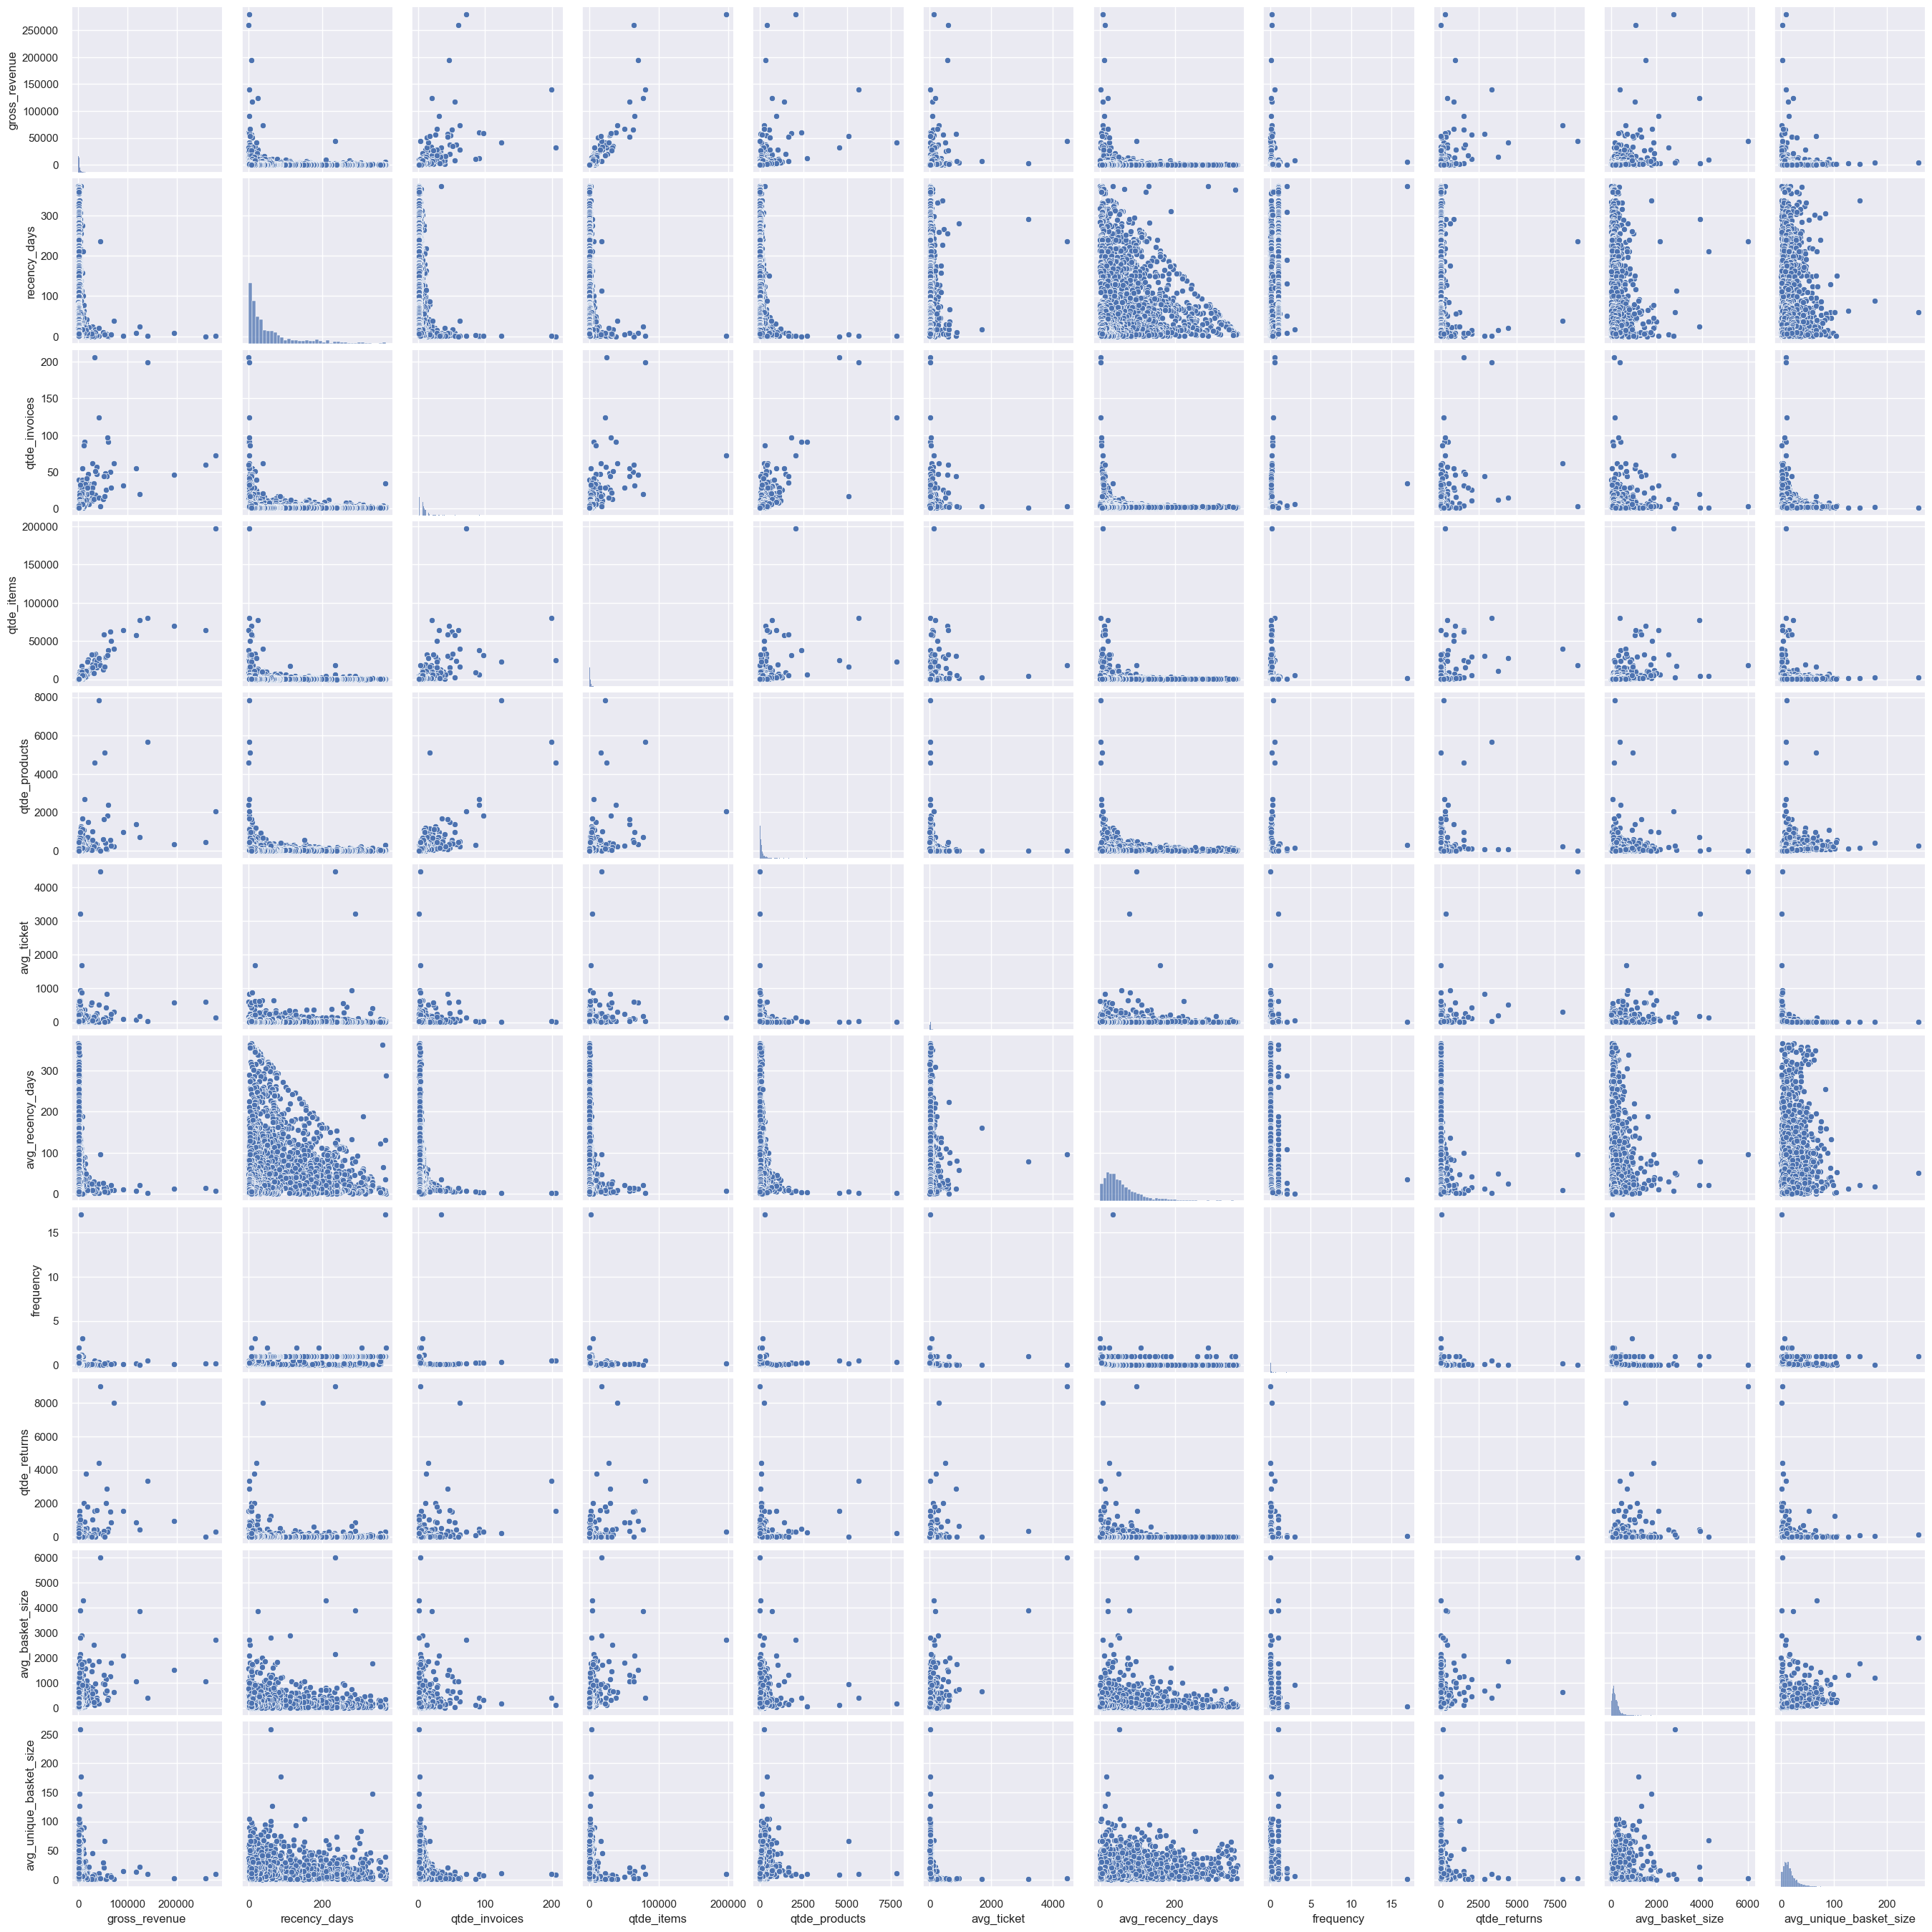

In [34]:
plt.figure( figsize=[25,12] )
sns.pairplot( df42)

## 4.3. Estudo do Espaço

In [107]:
df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [108]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
df43['qtde_invoices'] = mm.fit_transform( df43[['qtde_invoices']] )
df43['qtde_items'] = mm.fit_transform( df43[['qtde_items']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']] )
df43['avg_ticket'] = mm.fit_transform( df43[['avg_ticket']] ) 
df43['avg_recency_days'] = mm.fit_transform( df43[['avg_recency_days']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )
df43['avg_basket_size'] = mm.fit_transform( df43[['avg_basket_size']] )
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )

X = df43.copy()

### 4.3.1. PCA

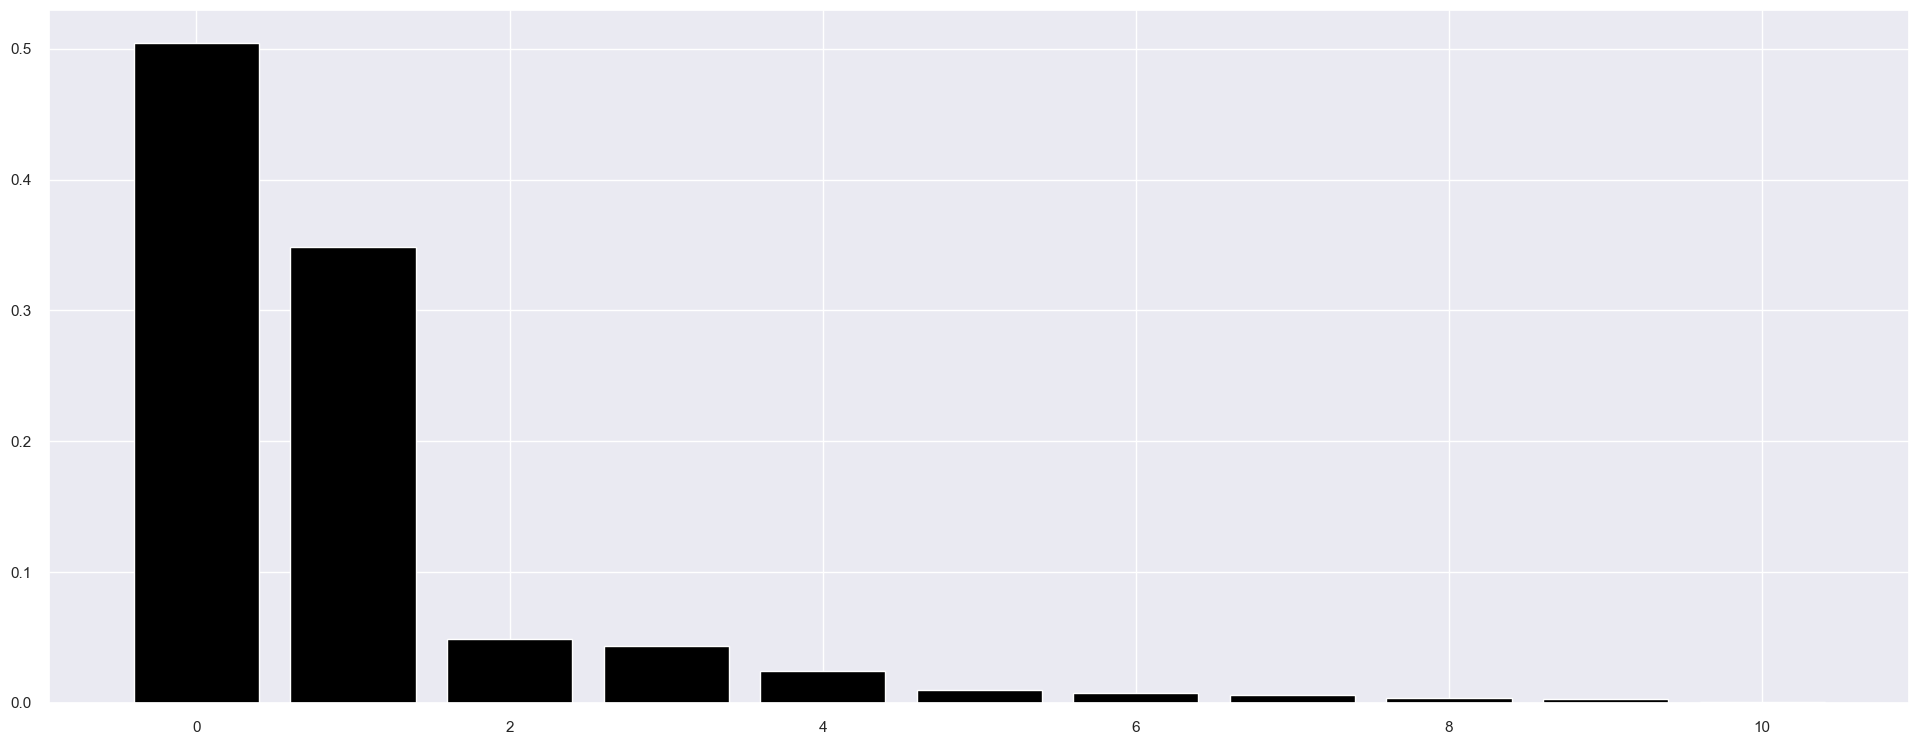

In [37]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explaned variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot: xlabel='0', ylabel='1'>

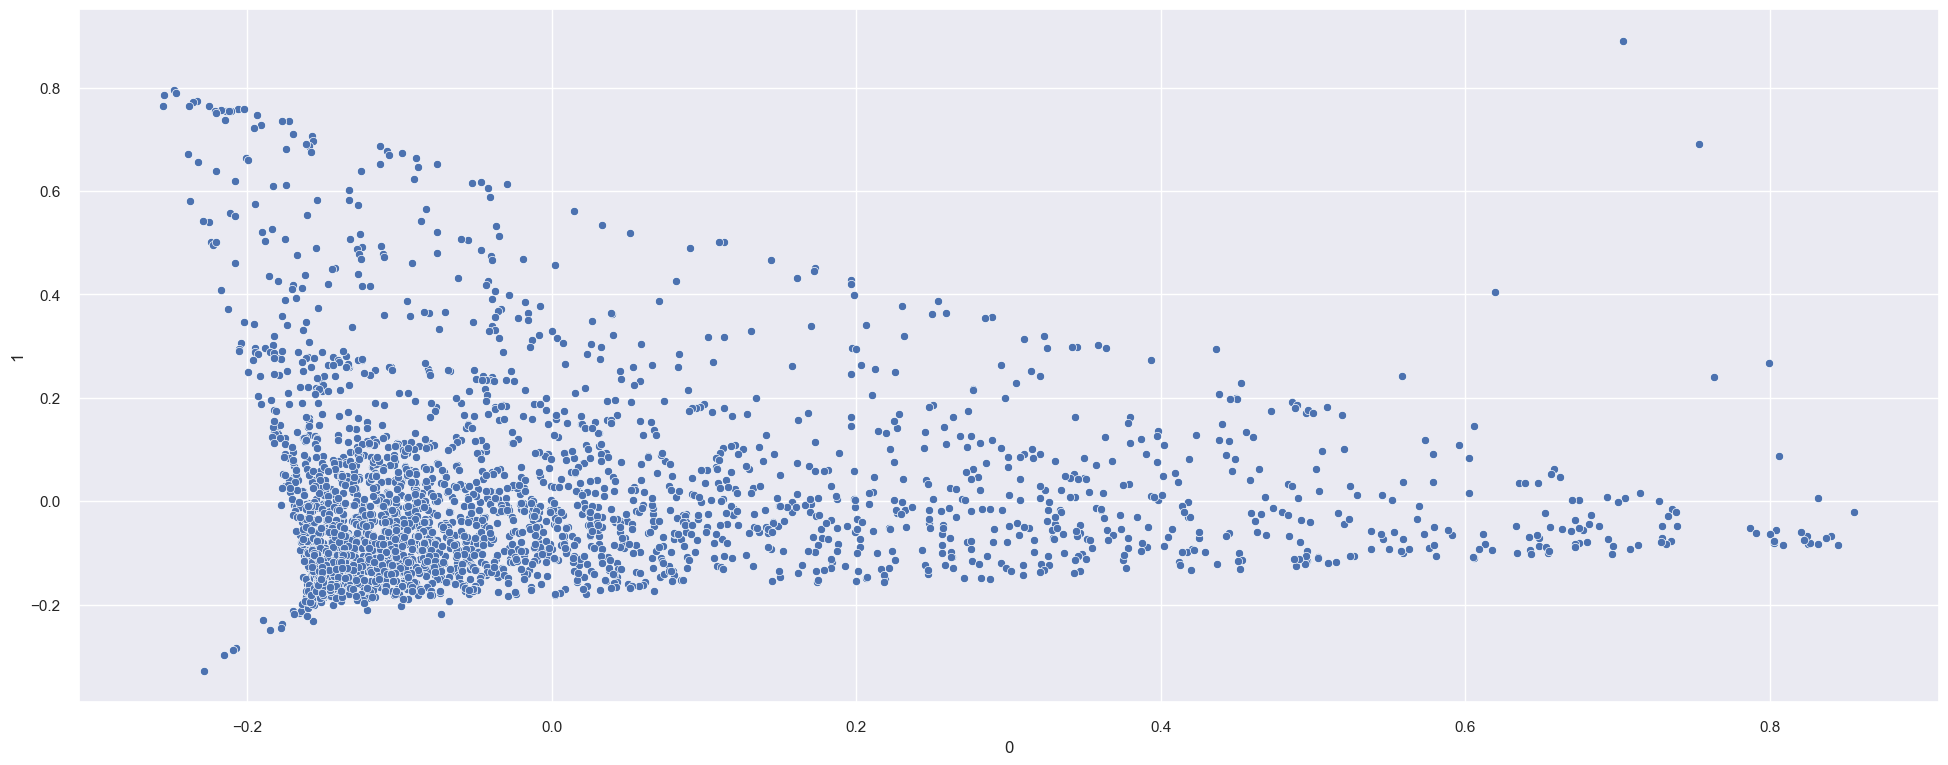

In [38]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

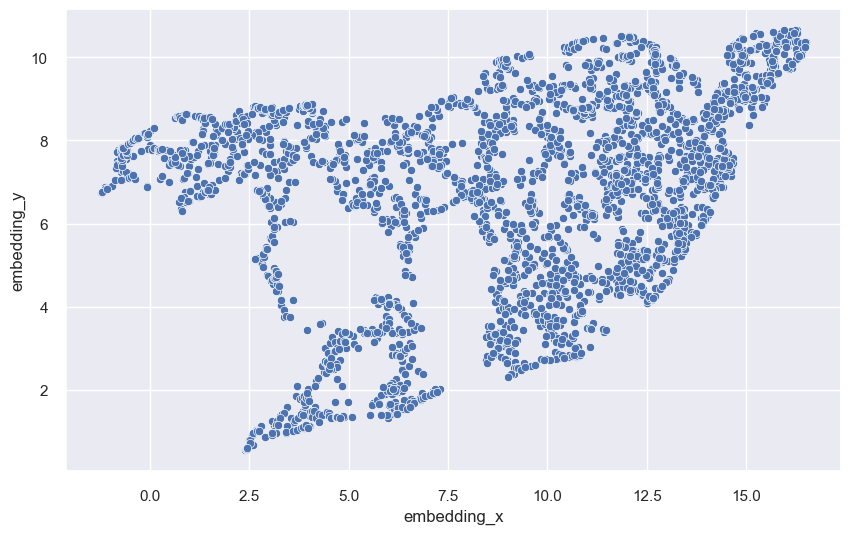

In [39]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )
plt.show()

### 4.3.2. t-SNE

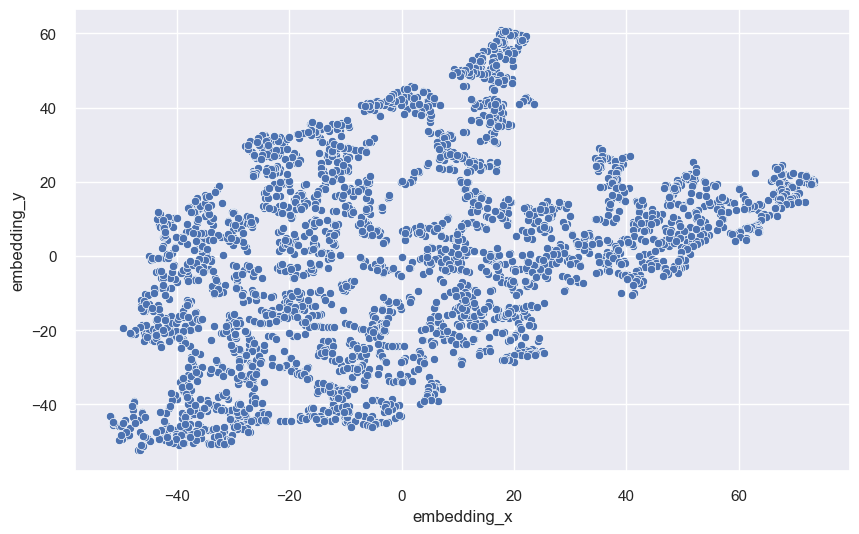

In [40]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )
plt.show()

### 4.3.3. Tree-Based Embedding

In [109]:
# training dataset
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )


RandomForestRegressor(random_state=42)

In [110]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [111]:
df_leaf.head(6)

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99
0  2991  3110  3387  3342  2288  3296  3254  3138  3171  3364  3157  3297  3069  3189  3127  3093  3012  3176  3127  3256  2917  2986  2905  3322  3348  3009  3036  2864  2928  3041  3316  3387  3143  3336  2942  3250  3412  3135  2961  3216  3366  3248  3221  3101  3182  3142  3289  3338  3350  3138  3193  2920  3088  3283  2975  3206  3166  3360  3220  2972  3422  2888  3338  3252  3023  3045  3230  3331  3062  3318  3304  3271  3318  3262  3104  3162  2955  3106  3219  3048  3221  3323  3136  3073  3293  3169  3353  3196  3133  3247  3181  3173  3195  3059  3039  3111  3204  2822  3357  3356
1  2961  2929  3048  2976  2740  2961  2896  2833  3112  2948  3102  2565  3061  3115  3015  3121  2986  3044  3066  2753  2798  3038  2772  2856  3017  3009  2794  2747  2839  3031  2869  3018  3046  2746  2906  2971  2975  2667  3054  2964  2688  2781  2992  3113  3130  3095  2912  2933  2977  3092  3165  3006  3057  3240  2928  2951  3129  3018  2860  2954  2994  2859  2897  2873  3004  3040  2887  2954  3045  2840  2863  2974  2963  2801  3060  2776  2902  3073  3161  3024  2924  2933  2984  2804  2909  3135  2941  3152  3092  2850  2516  2867  2946  2993  3139  3067  2911  2801  2968  3006
2  3632  3608  3586  3413  3572  3658  3630  3546  3680  3615  3624  3579  3544  3651  3563  3567  3583  3655  3555  3463  3513  3633  3604  3520  3569  3646  3573  3603  3587  3721  3438  3671  3594  3634  3577  3614  3548  3521  3597  3483  3658  3401  3634  3499  3536  3603  3424  3649  3634  3553  3628  3503  3567  3612  3683  3631  3610  3645  3568  3571  3613  3588  3583  3689  3456  3622  3652  3573  3555  3623  3589  3427  3576  3605  3545  3558  3598  3565  3536  3497  3539  3449  3477  3427  3528  3597  3584  3699  3587  3563  3601  3441  3560  3482  3604  3454  3529  3616  3568  3654
3  1287  1418  1754  1500  1913  2226  2109  1994  1642  1730  2051  2298  1345  1600  1526  1794  1902  1605  1424  1421  1827  1449  1468  1514  1145  1478  1514  1533  1666  1307  1951  1531  1511  1455  1049  1545  2166  2204  1662  1528  1501  1441  1464  1815  1400  1489  1551  1436  1380  1667  1825  1499  1353  1593  2105  1493  2013  1739  1298  2129  1614  1239  1888  1856  1487  1482  1413  1808  1067  1696  2305  1589  1284  2122  1273  2047  1517  1501  1925  1469  1914  1426  1348  1461  1486  1493  1390  1420  1671  1532  1903  1723  2041  1890  1974  2246  1508  1196  1997  2113
4   358   717   580   694   146   712   736   690   191   199   579   722   668   195   149   609   575   418   183   391   177   712   417   200   631   212   439   206   147   729   705   203   213   205   235   721   597   205   188   973   517   869   219   591   894   677   812   605   690   608   595   186   758   520    80   552   700   215   722   604   233   730   191   208   669   455   473   512   459   625   714   229   328   623   716   201   720   182   114   228   215   696   757   218   683   178   305   725   689   810   333   194   584   544   198   158   189   704   706   185
5  3239  3324  3378  3333  3258  3326  3241  3442  3365  3355  3320  3309  3321  3362  3354  3361  3320  3297  3173  3279  3286  3159  3347  3311  3391  3354  3267  3159  3151  3443  3289  3349  3369  3340  3370  3359  3188  3368  3384  3288  3301  3203  3361  3196  3300  3179  3309  3355  3357  3366  3223  3271  3176  3348  3160  3233  3216  3373  3208  3314  3392  3288  3345  3388  3314  

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

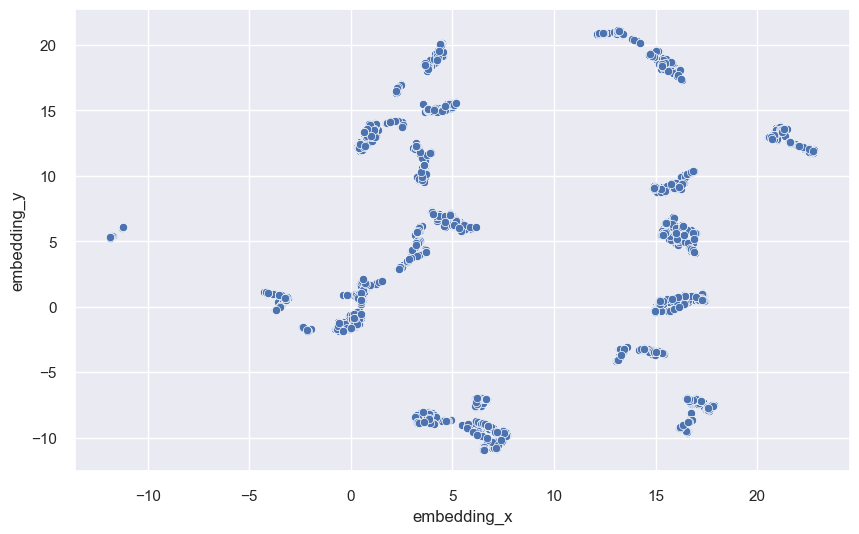

In [112]:
# reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_tree )

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.0. Data Preparation</p></div>    

In [113]:
#df5 = df4.copy()
df5_aux = df_tree.copy()

In [114]:
#mm = pp.MinMaxScaler()
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()
#
#df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
#df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
##df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
##df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
##df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
##df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
##df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
##df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

In [70]:
df5.head()

customer_id  gross_revenue  recency_days  qtde_invoices  qtde_items  qtde_products  avg_ticket  avg_recency_days  frequency  qtde_returns  avg_basket_size  avg_unique_basket_size
0        17850       0.019292      0.997319       0.160976    0.008799       0.037774    0.003594          0.094521   1.000000      0.004438         0.008317                0.001614
1        13047       0.011559      0.150134       0.039024    0.007056       0.021695    0.003763          0.071918   0.001345      0.003883         0.025539                0.044307
2        12583       0.024000      0.005362       0.068293    0.025538       0.029479    0.006010          0.060788   0.002052      0.005547         0.055623                0.028594
3        13748       0.003375      0.254692       0.019512    0.002225       0.003446    0.007126          0.251142   0.000734      0.000000         0.014447                0.017774
4        15100       0.003116      0.892761       0.009756    0.000401       0.000255    0.065116          0.020822   0.003985      0.002441         0.004272                0.000515

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">6.0. Feature Selection</p></div>     

In [73]:
#cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [115]:
#df6 = df5[cols_select].copy()
df6 = df_tree.copy()

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.0. Hiperparameter Fine-Tunning</p></div>      

In [116]:
#X = df6.drop( columns=['customer_id'] )
X = df_tree.copy()

In [117]:
X.head()

embedding_x  embedding_y
0    16.737152    10.245848
1    15.396250     5.676272
2    14.127540    20.296495
3    -4.193302     1.100995
4     2.208363    16.462225

In [125]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 26, 1)

## 7.1. K-Means

In [126]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

Text(0.5, 1.0, 'Silhouette Score x K')

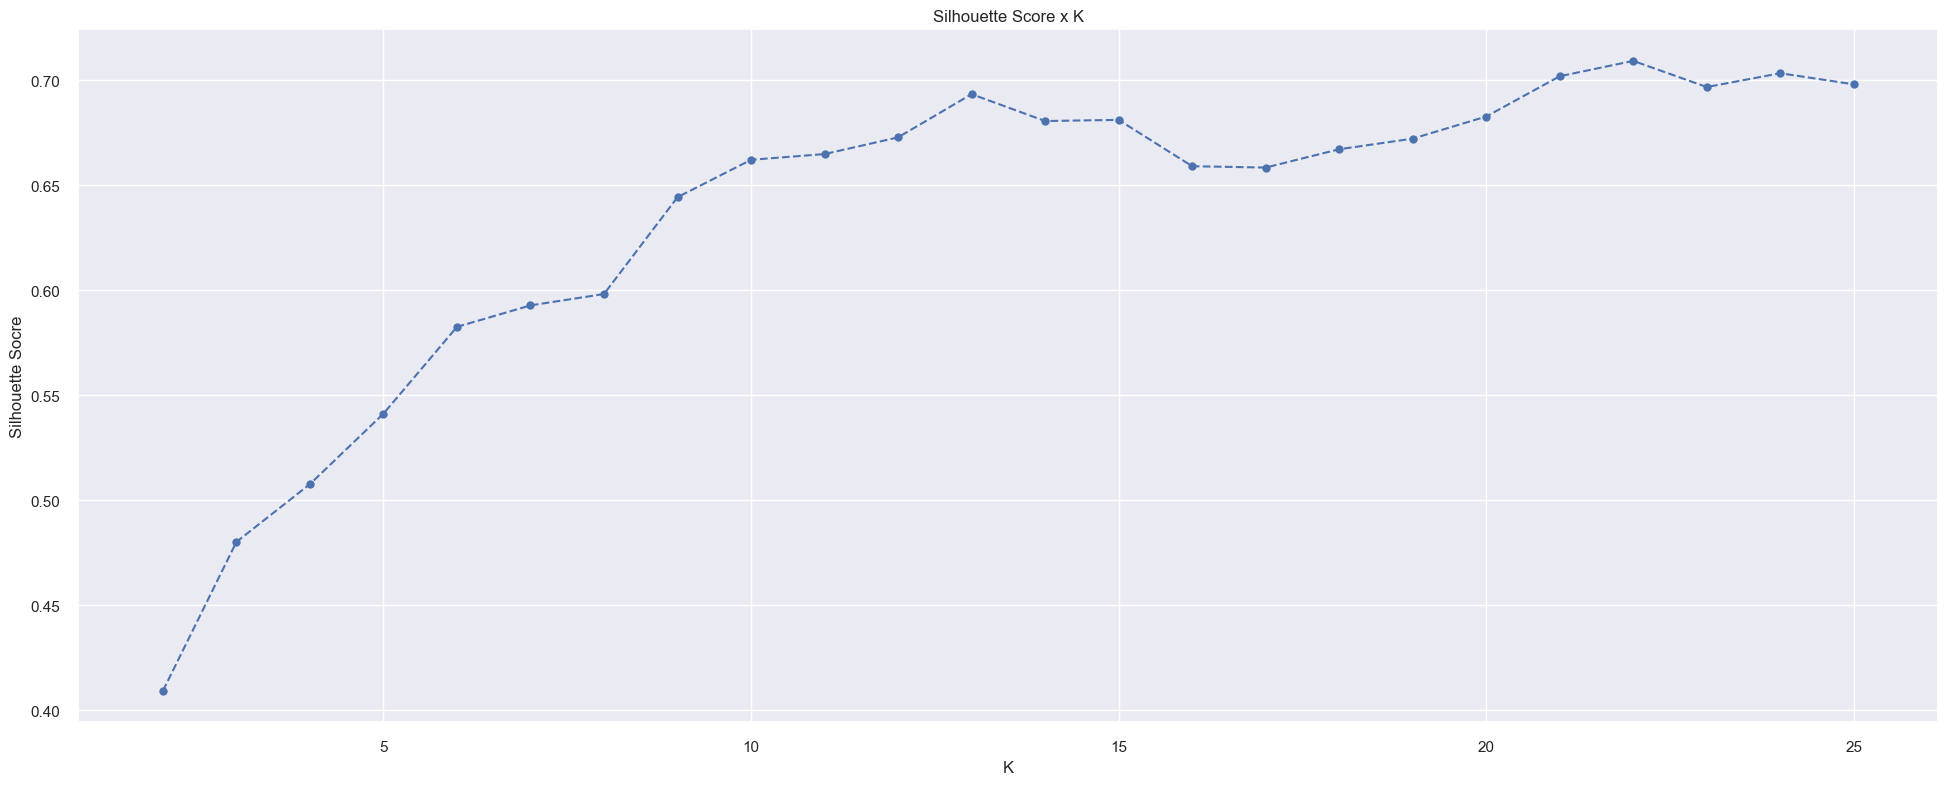

In [127]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Socre' )
plt.title( 'Silhouette Score x K' )

## 7.2. GMM

In [128]:
gmm_list =[]
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

Text(0.5, 1.0, 'Sil x K')

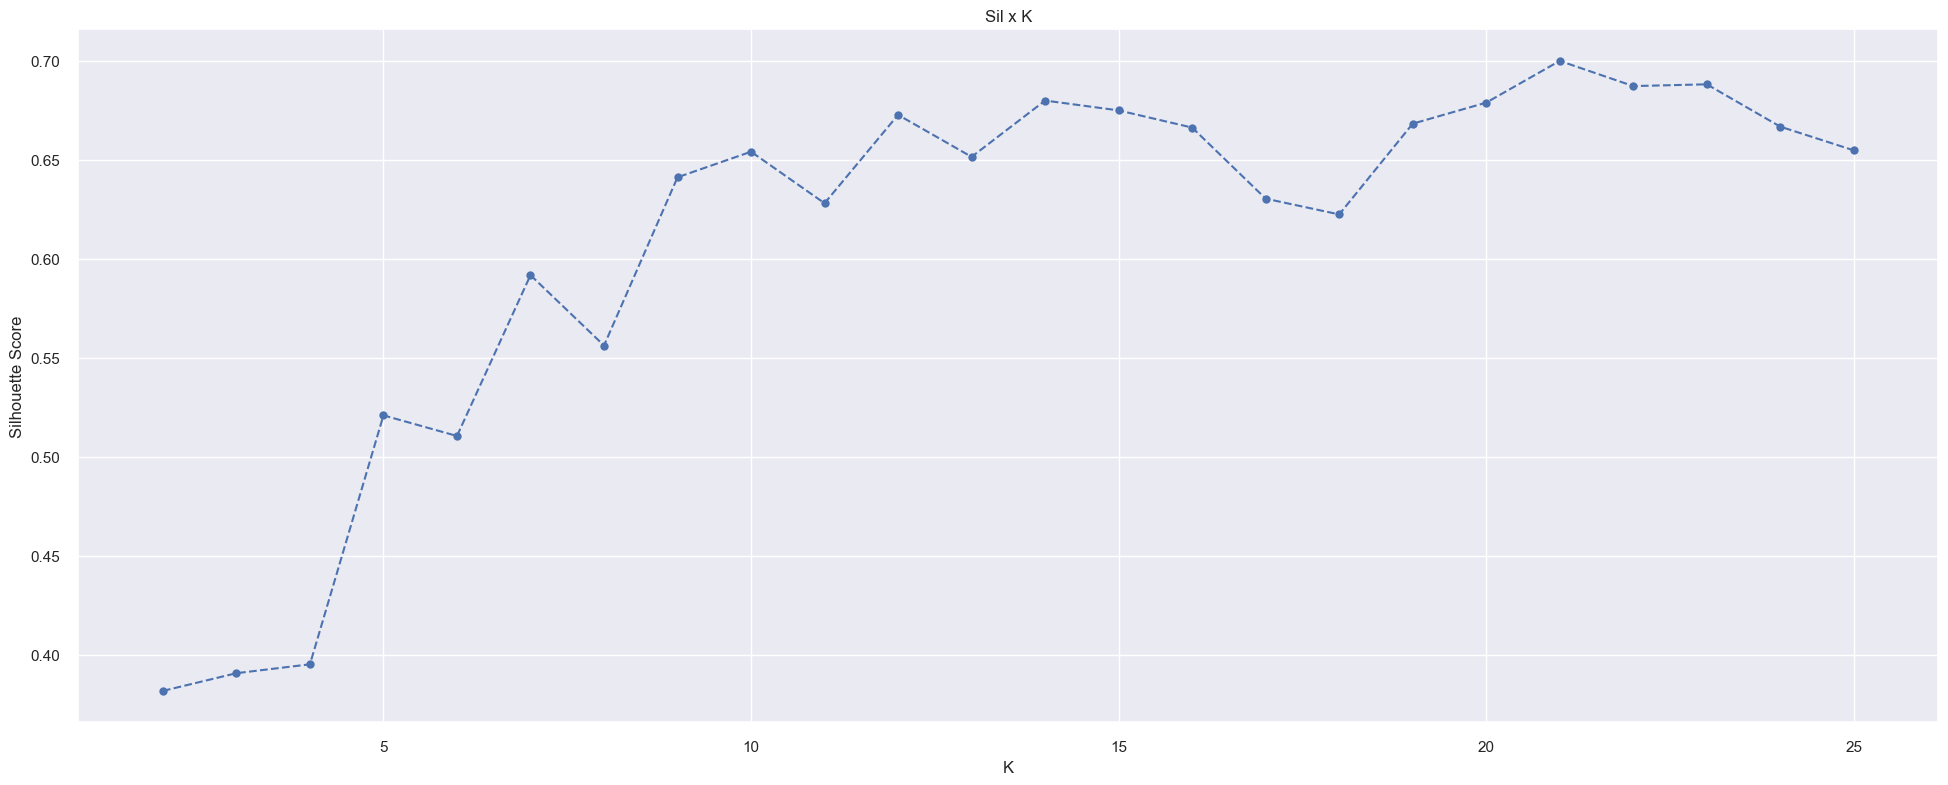

In [129]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Sil x K' )

## 7.3. Hierarchical Clustering

In [130]:
# model definition and trainig
hc_model = hc.linkage( X, 'ward' )

[]

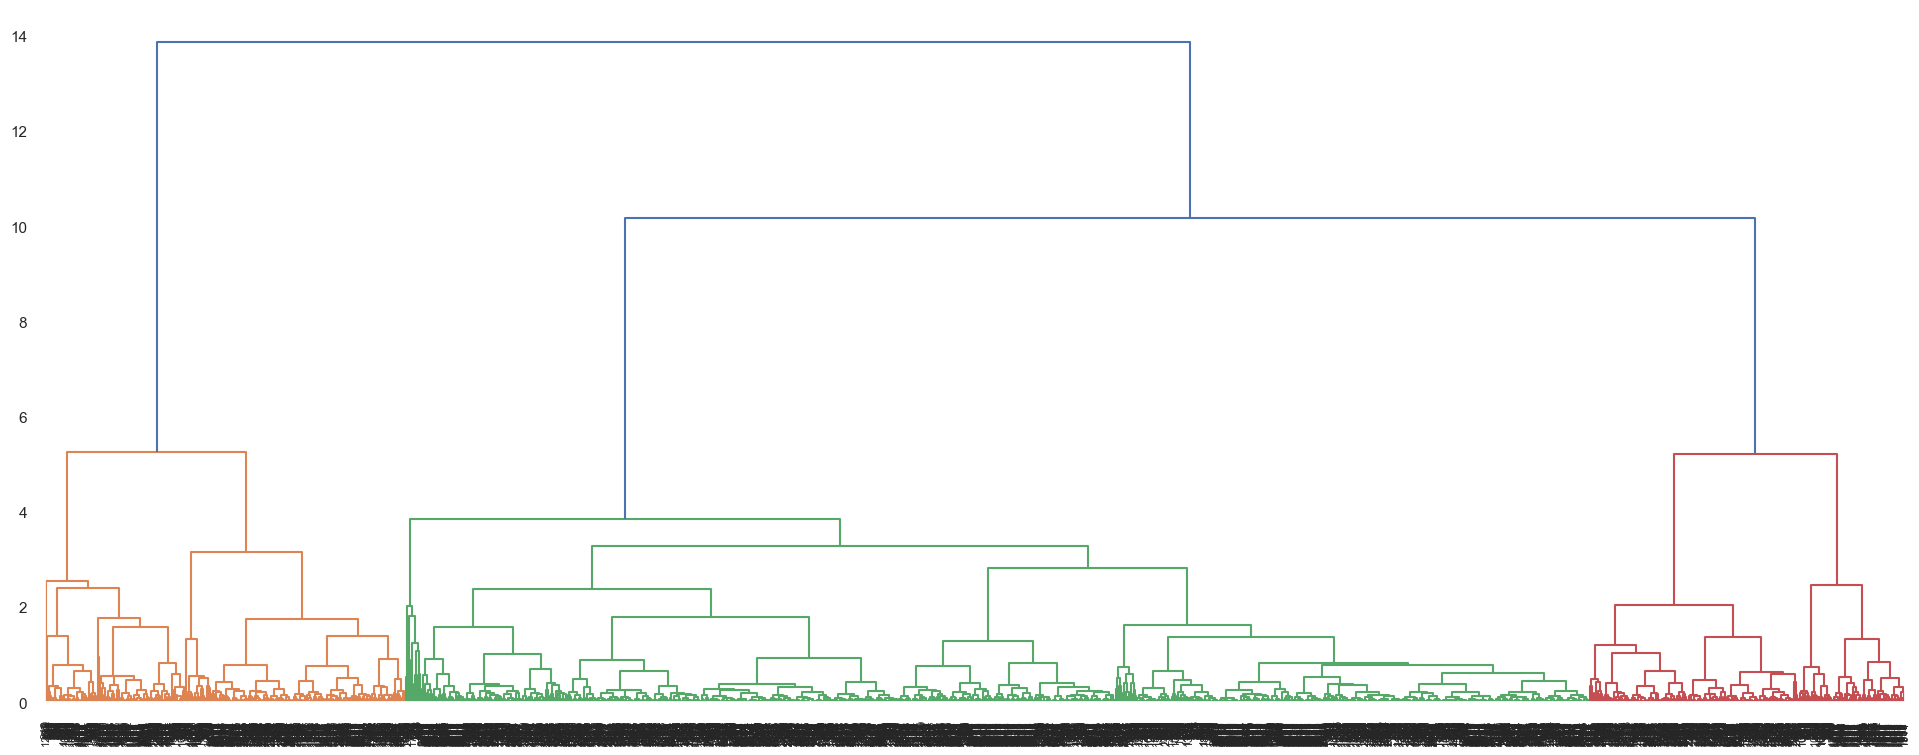

In [58]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

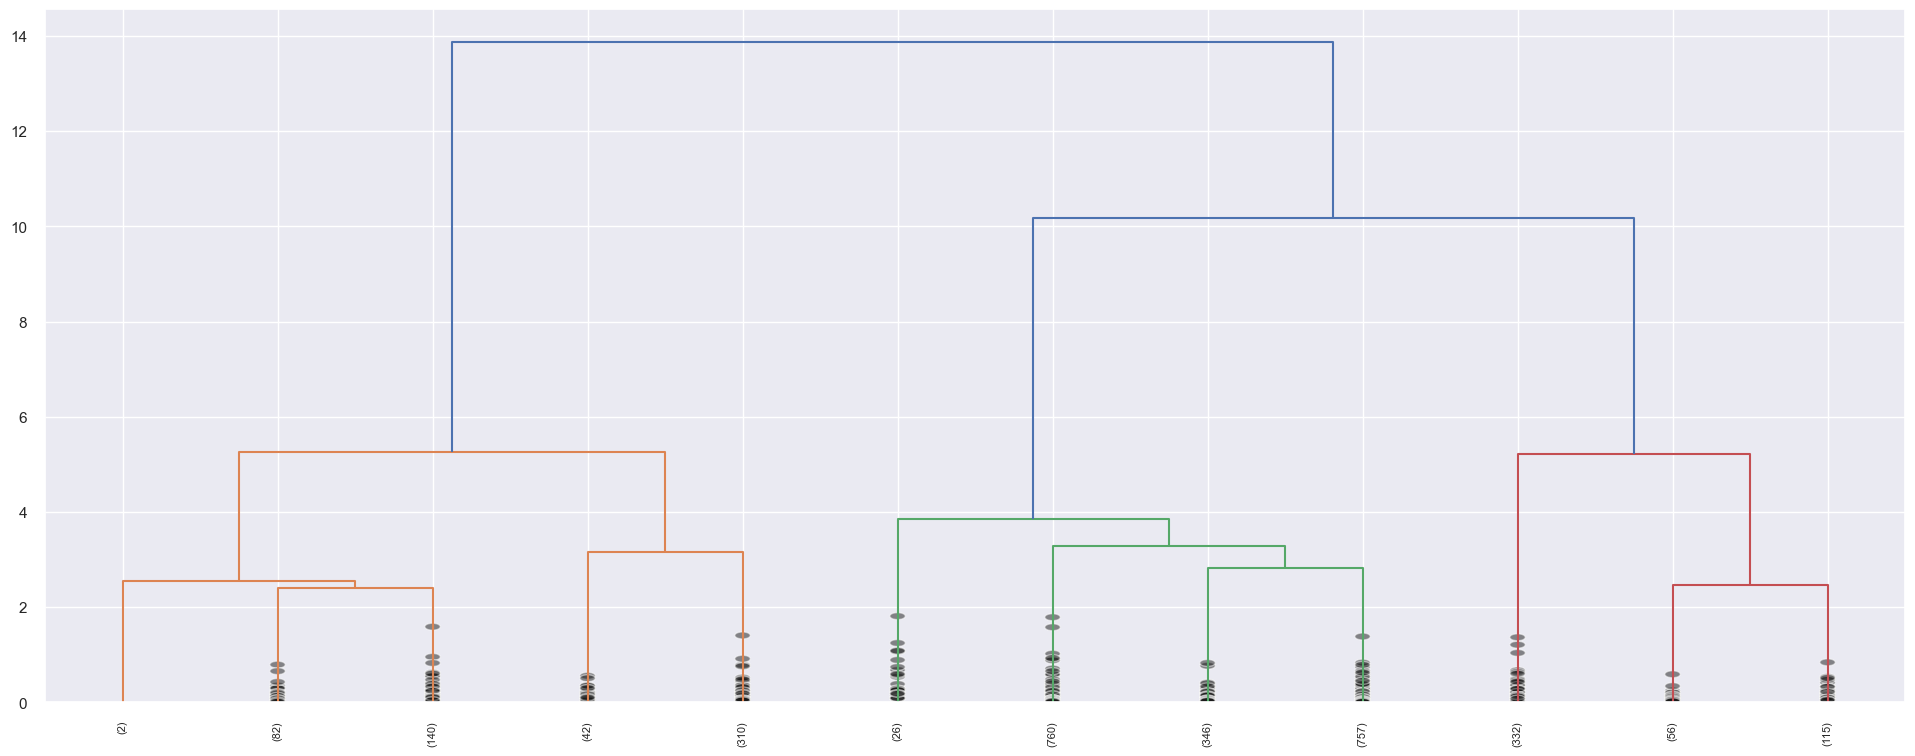

In [59]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1. HClustering Silhouette Score

In [131]:
hc_list = []
for k in clusters:
    # model definition e training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

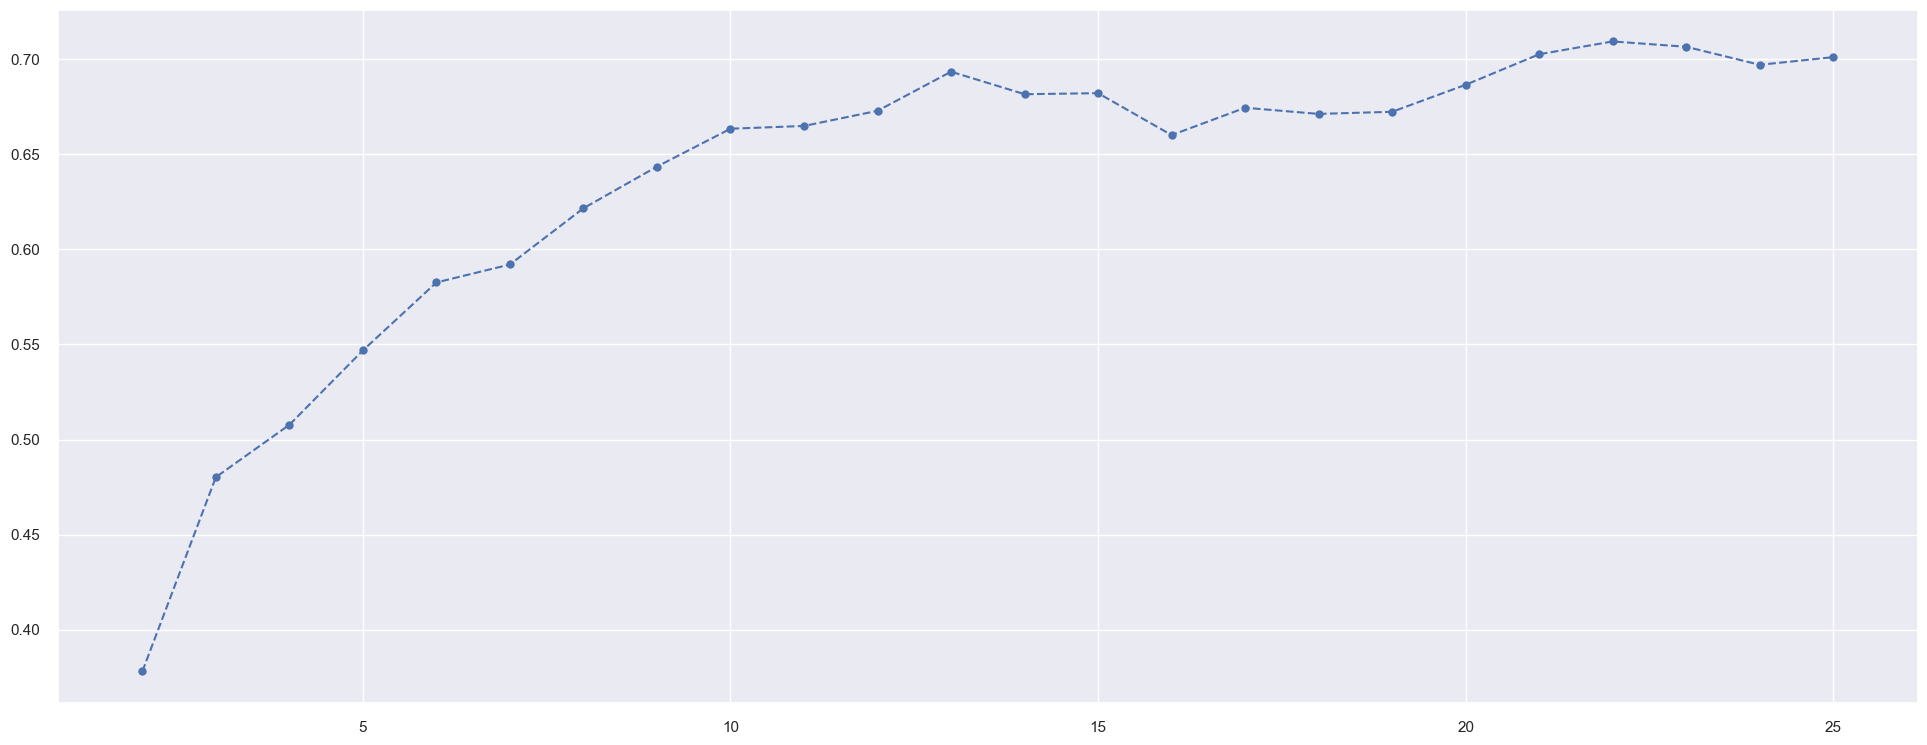

In [132]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [86]:
eps=0.01
min_samples=20

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# model training and predict
labels = dbscan_model.fit_predict( X )

sil = mt.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
#print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
#print( unique(labels) )

Silhouette Score: 0.19087687925999902


In [87]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

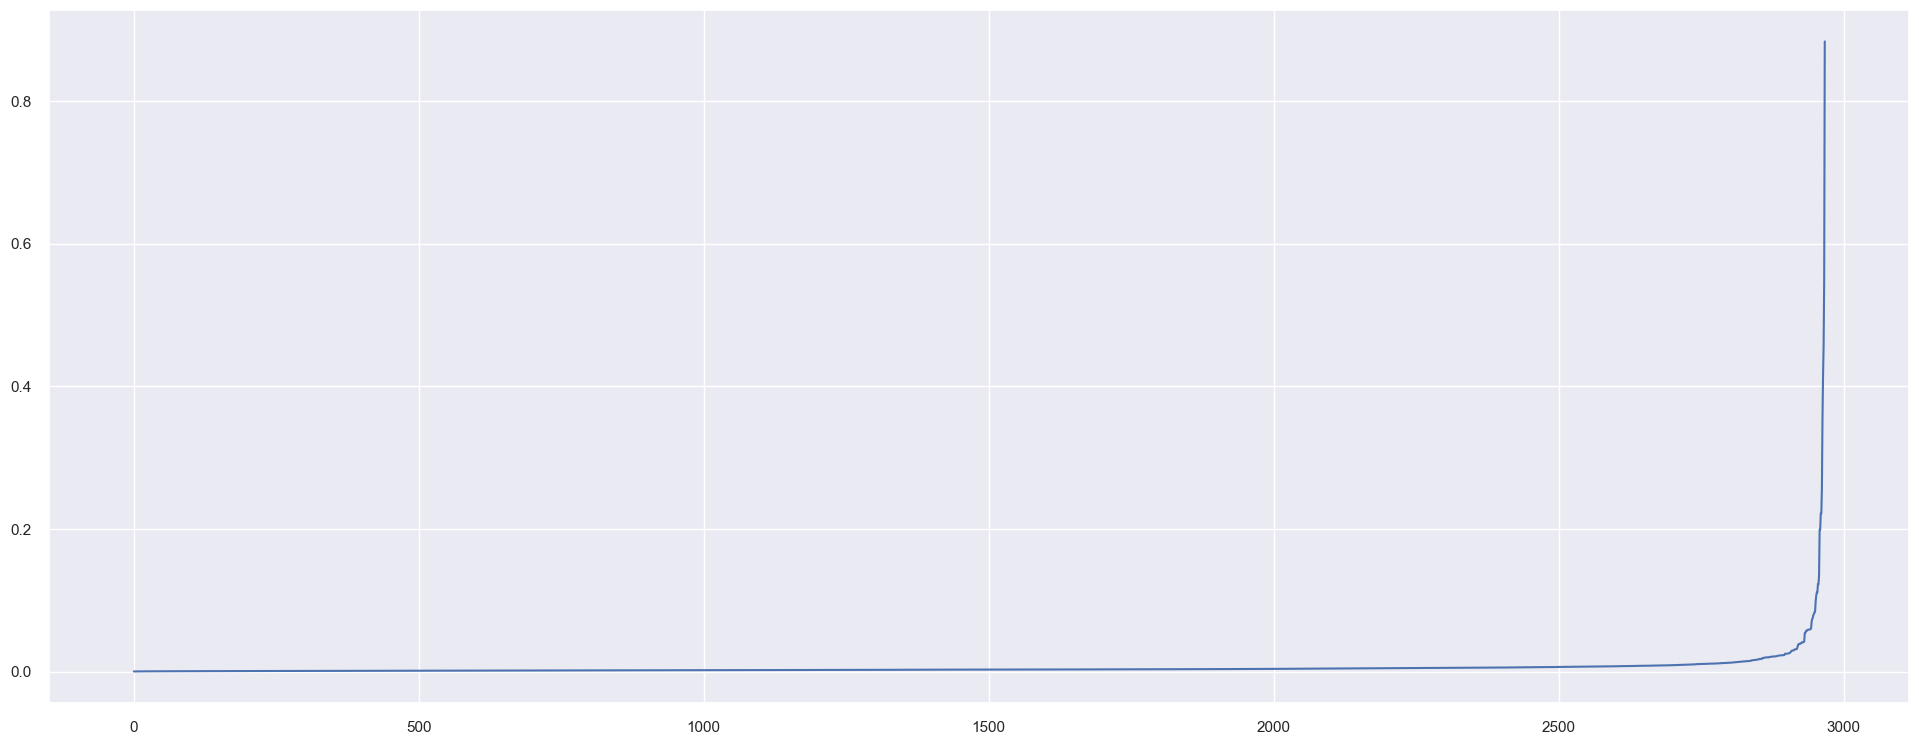

In [88]:
distances = np.sort( distances, axis=0 )
distances = distances[:, 1]
plt.plot( distances )

In [89]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [133]:
df_results = pd.DataFrame( 
    {'kMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
     ).T
df_results.columns = clusters

In [134]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

For K = 2. Silhouette Score: 0.7192060260253784
For K = 3. Silhouette Score: 0.6388516898421132
For K = 4. Silhouette Score: 0.5042762577534418
For K = 5. Silhouette Score: 0.5169900179758833
For K = 6. Silhouette Score: 0.5140129787331982
For K = 7. Silhouette Score: 0.4317755766195541


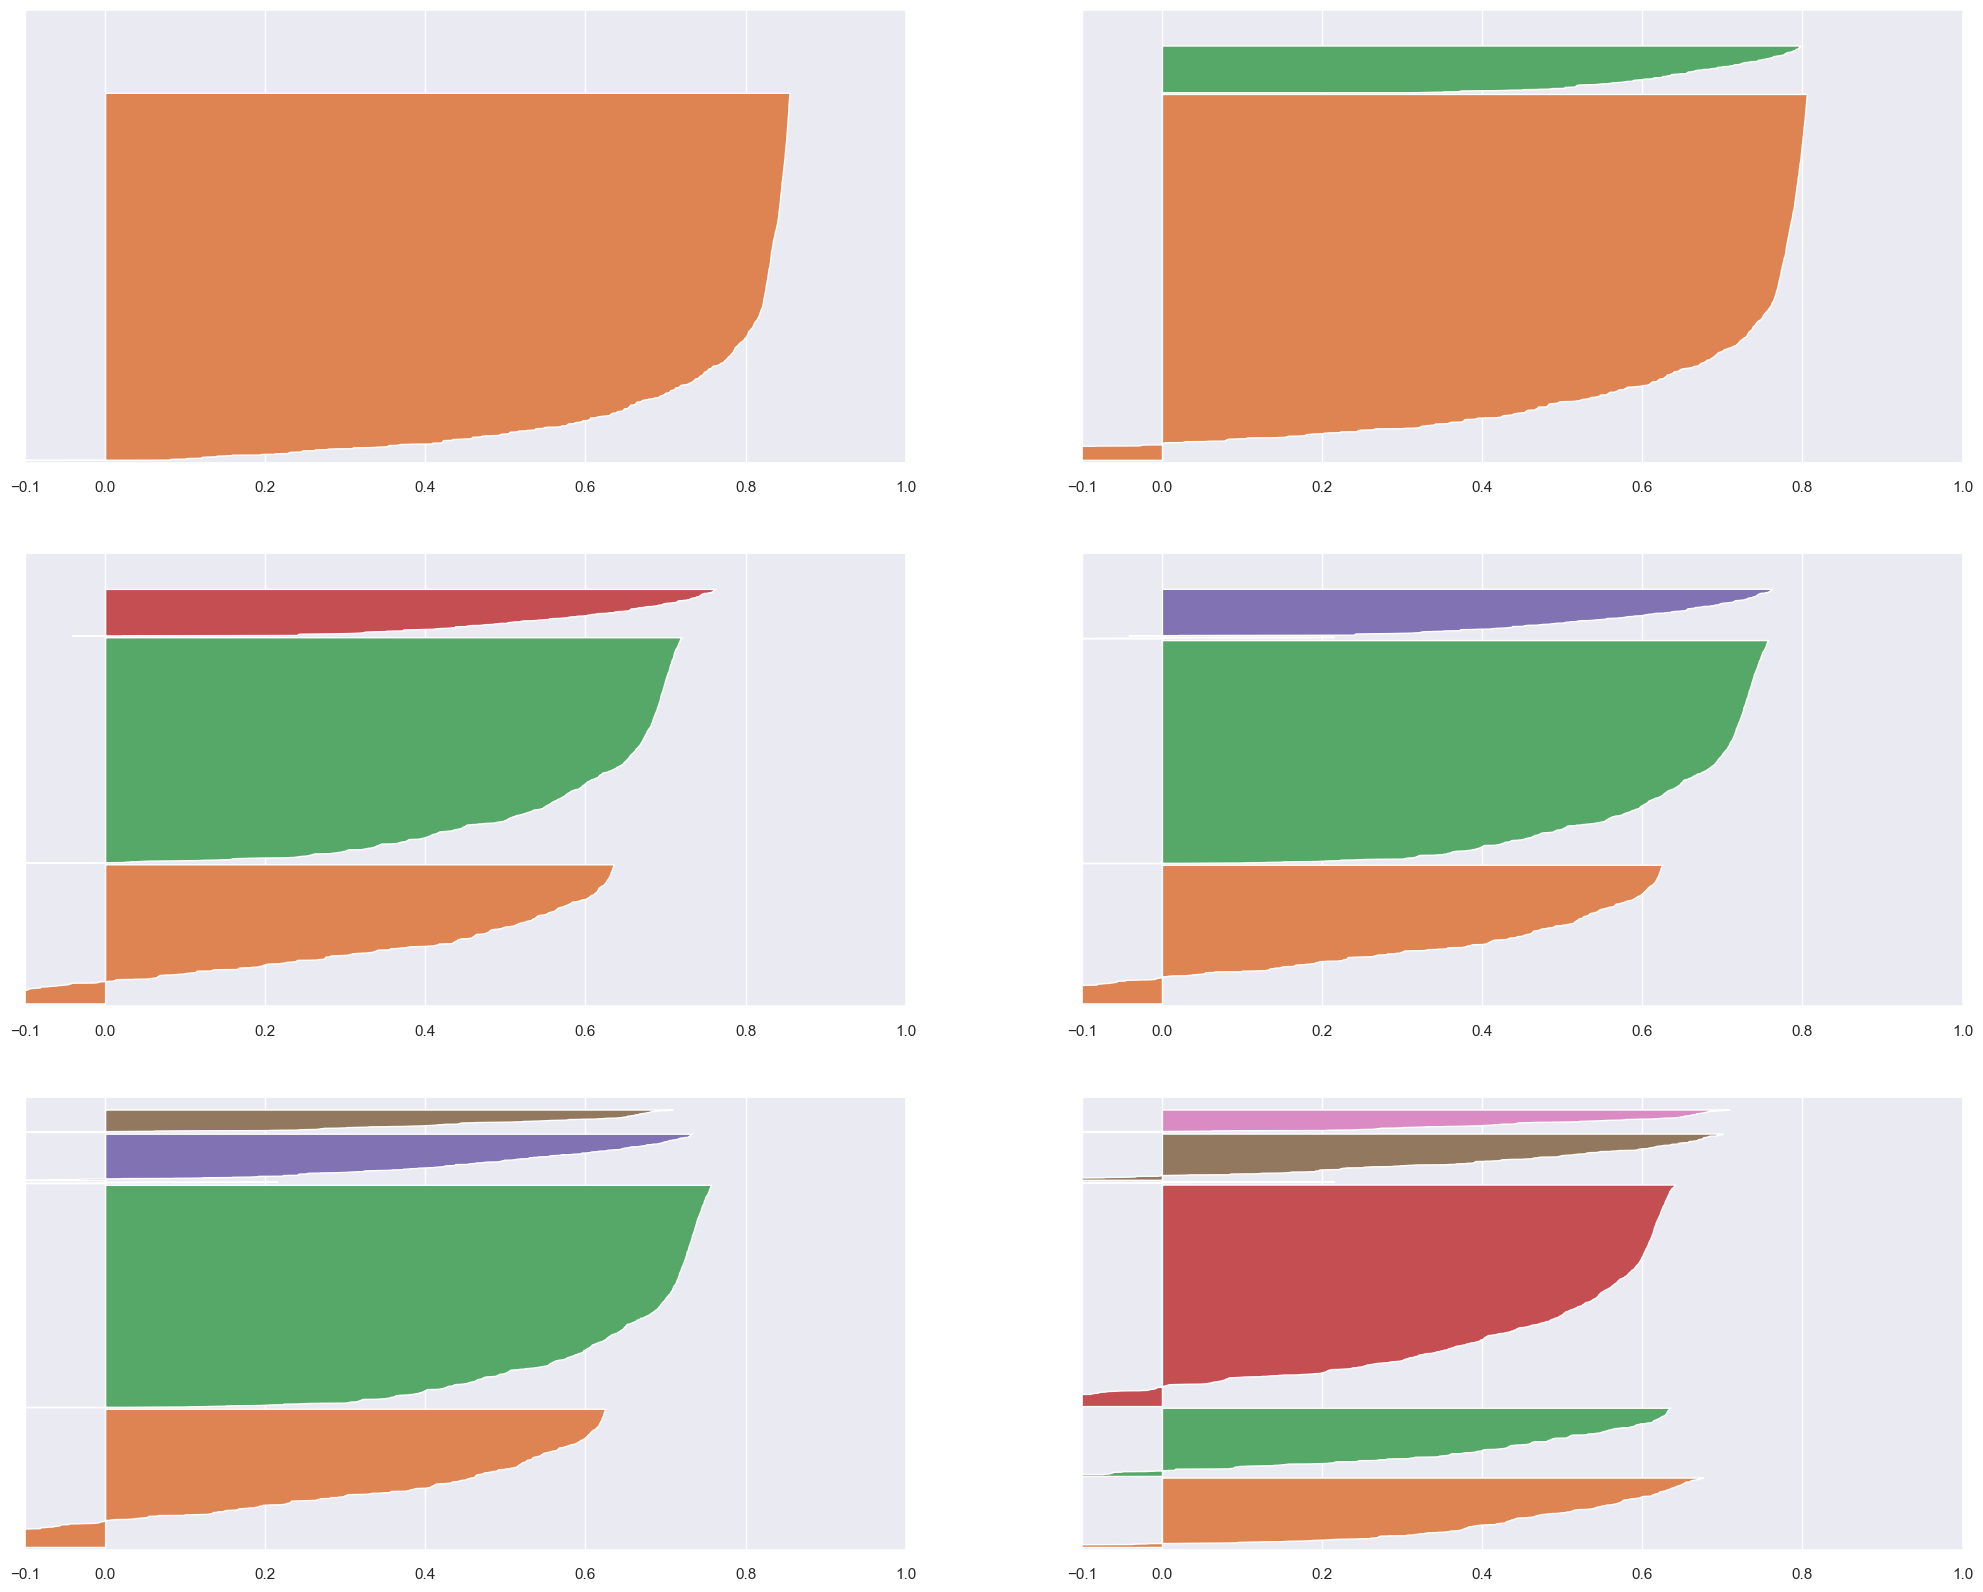

In [92]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1 ] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )

    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = mt.silhouette_score( X, labels, metric='euclidean' )
    print( 'For K = {}. Silhouette Score: {}'.format( k, ss ) )
    
    samples_silhouette_values = mt.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels==i ]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

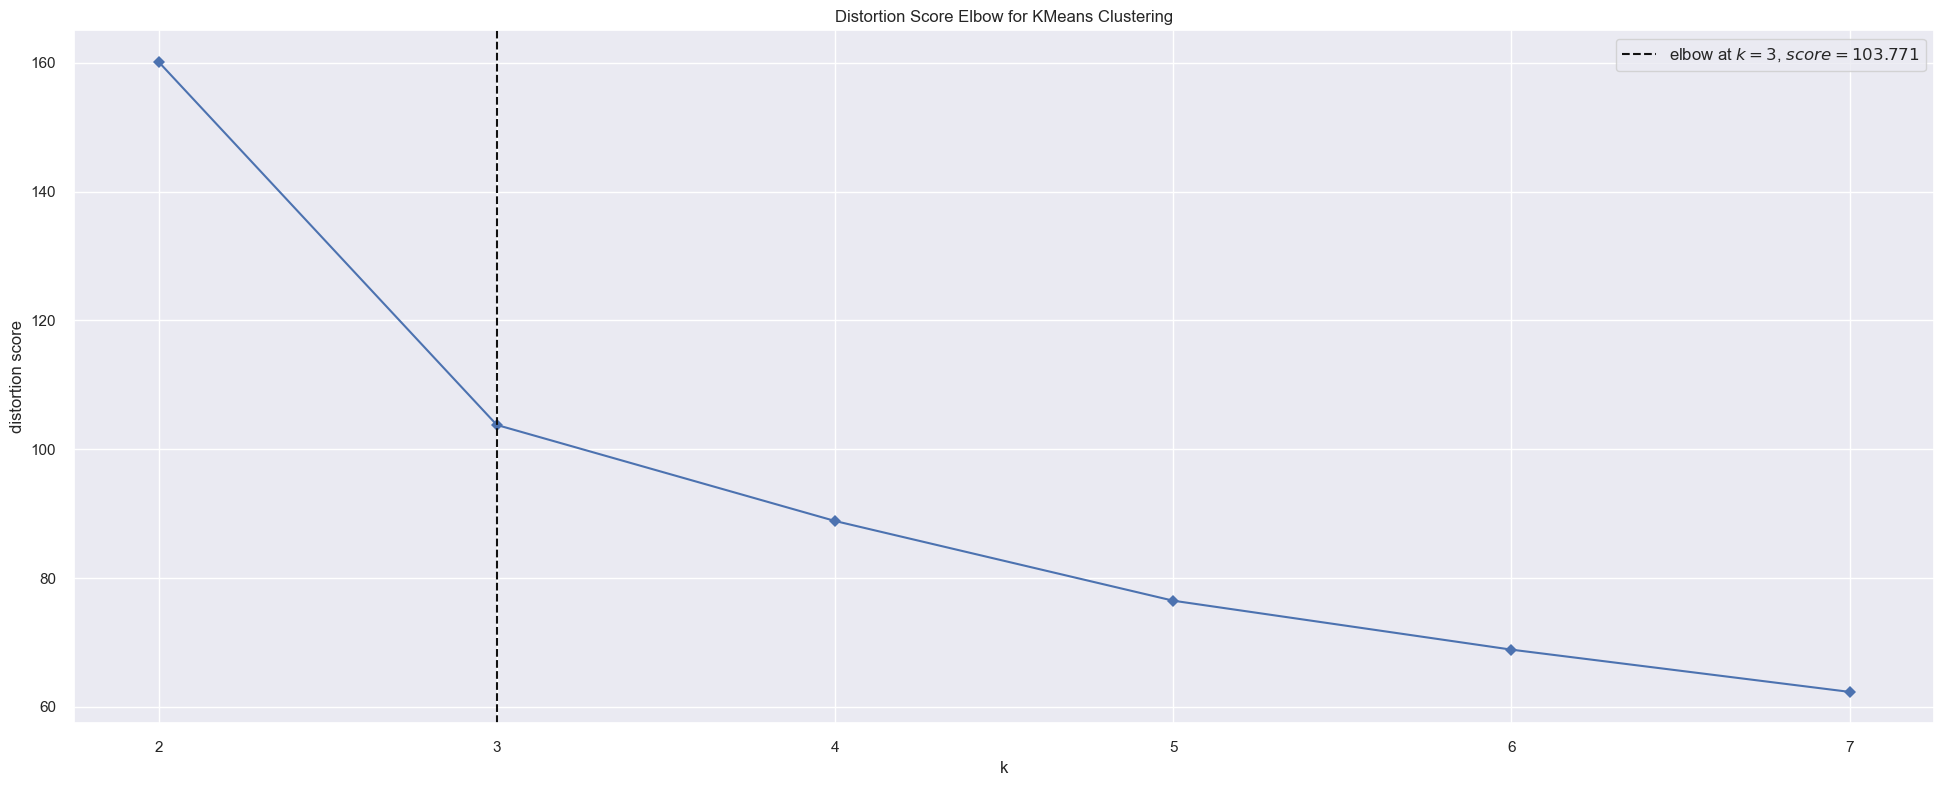

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

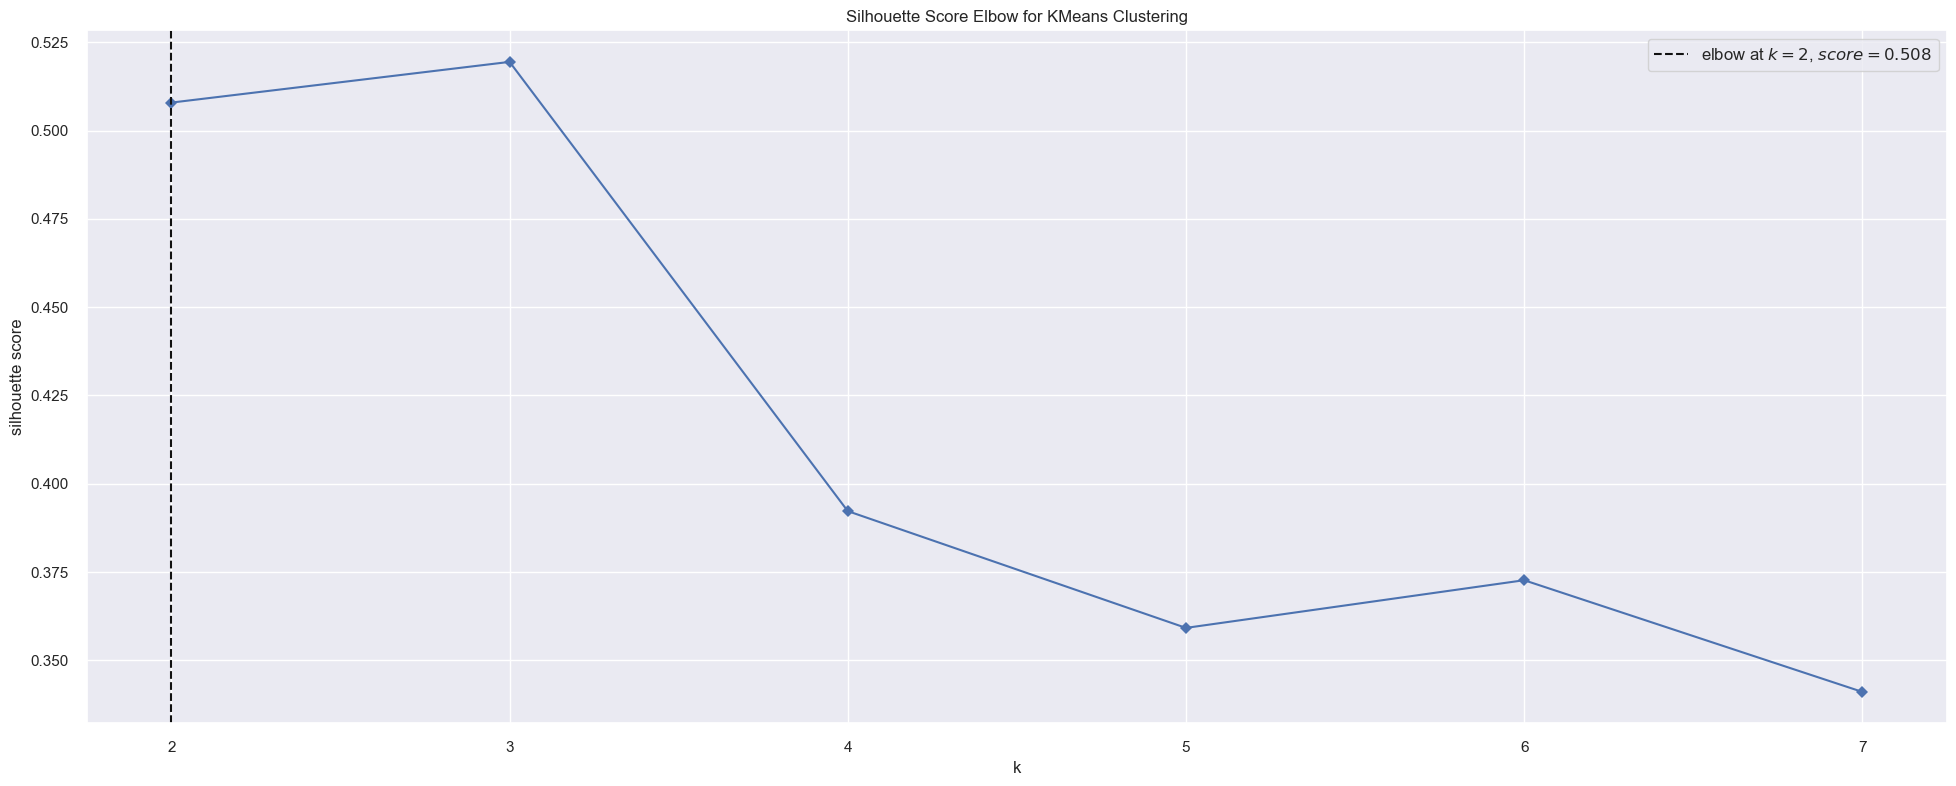

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [61]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette',  timings=False )
kmeans.fit( X )
kmeans.show()

## 7.1. Sillhouette Analysis

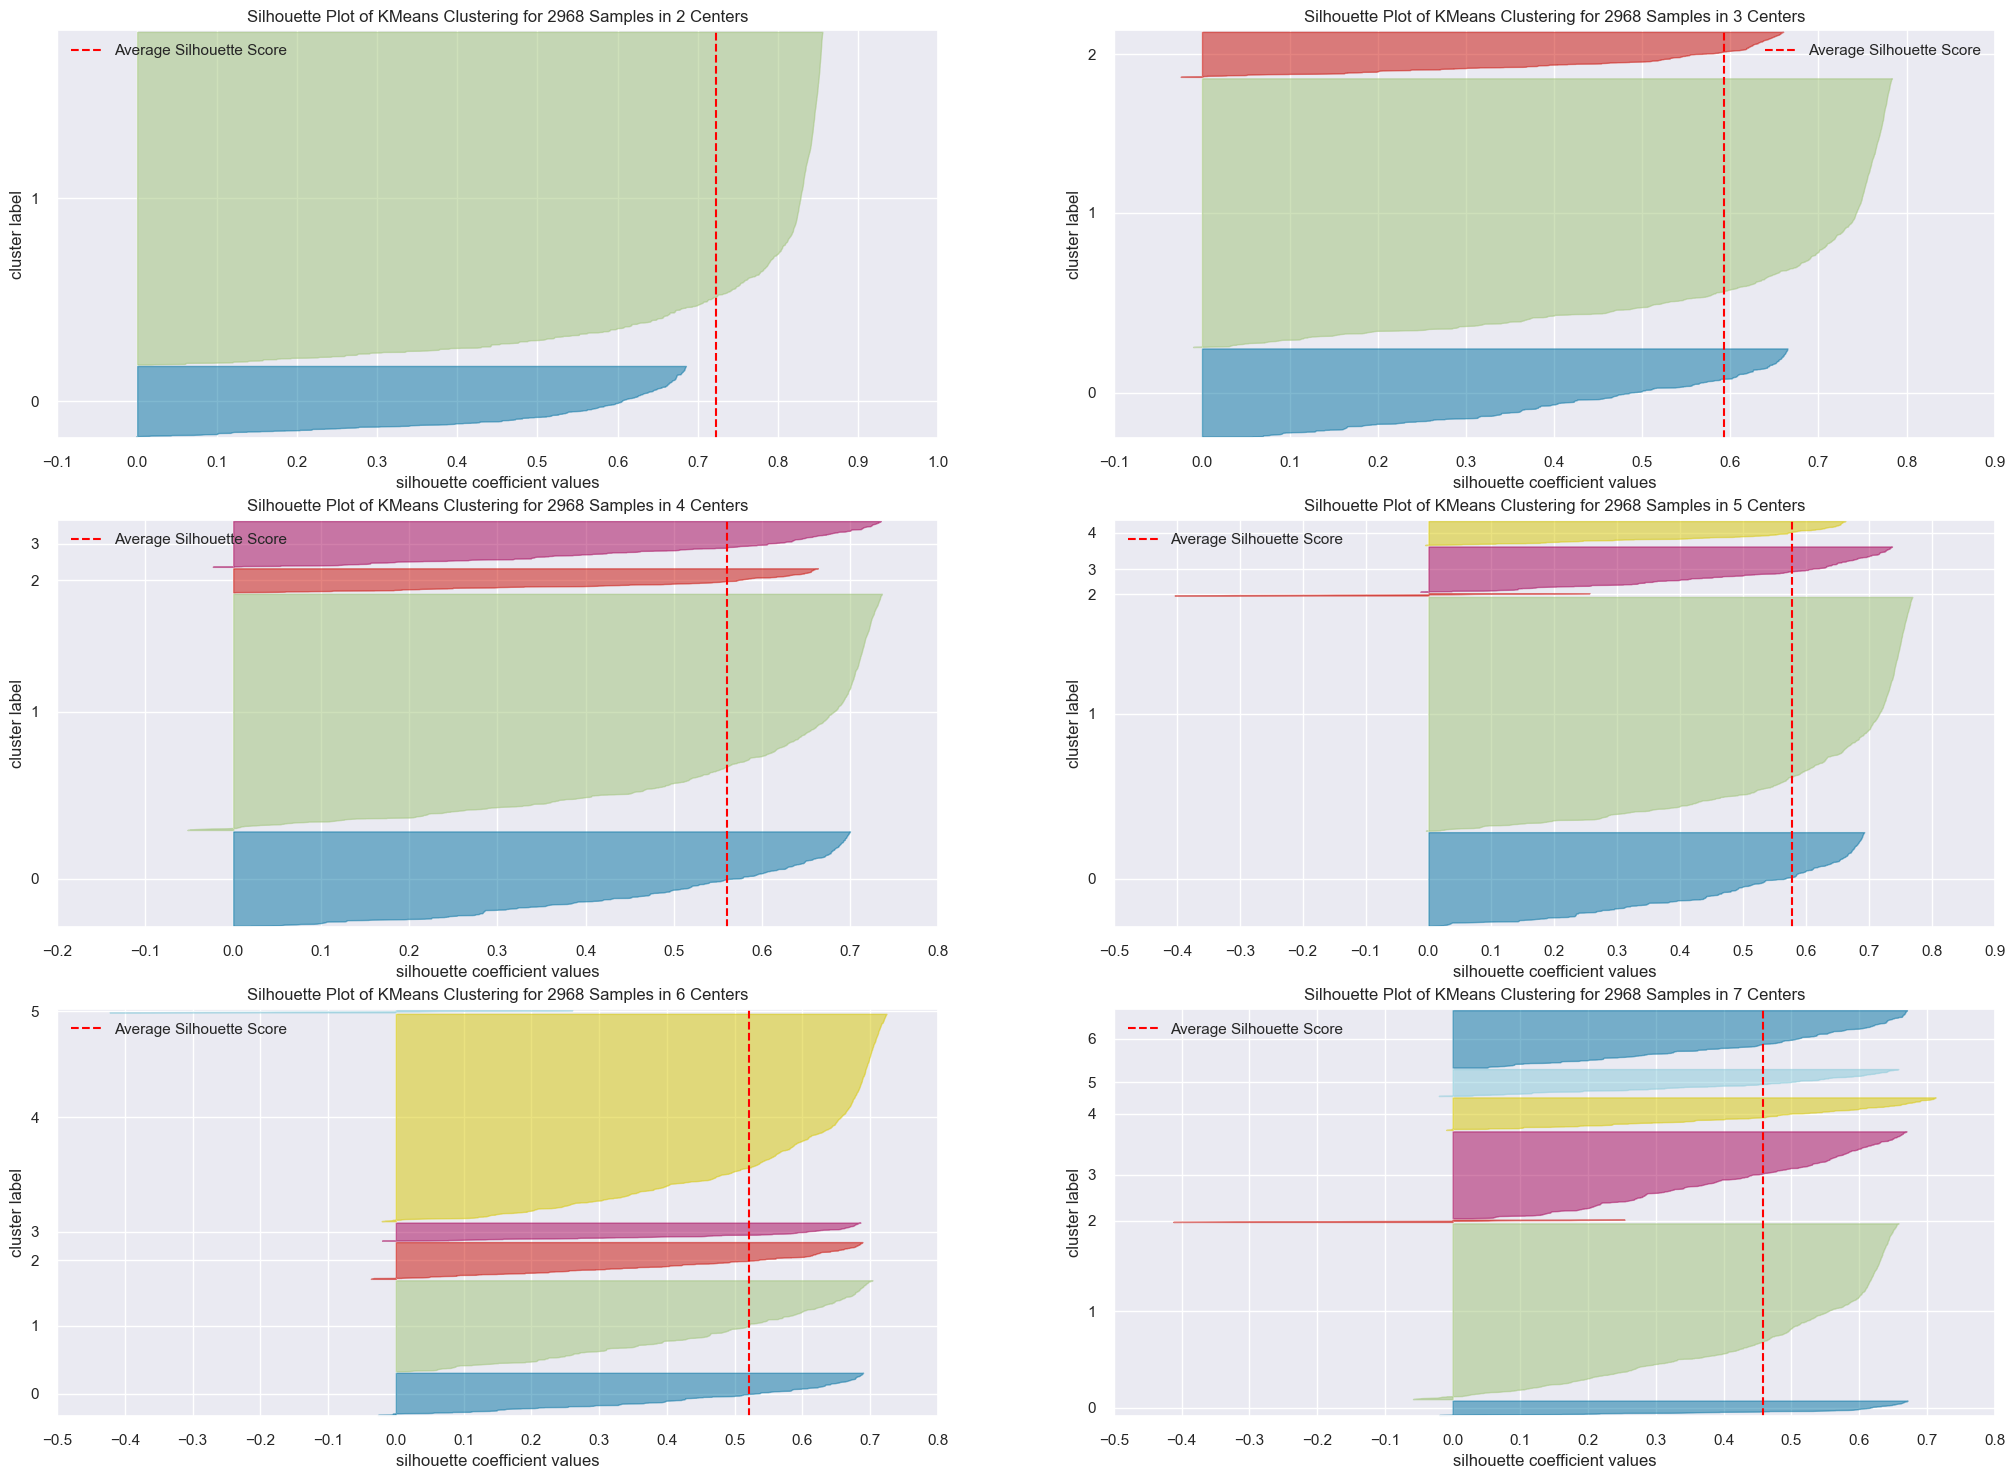

In [93]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">8.0. Model Training</p></div>       

## 8.1. K-Means

In [141]:
# model definition
k = 7
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# model training
kmeans.fit( X )

# clustering 
labels = kmeans.labels_

In [146]:
k=7
# model definition
kmeans = mx.GaussianMixture( n_components=k )

# model training
kmeans.fit( X )

# model predict
labels = kmeans.predict( X )

## 8.2. Cluster Validation

In [142]:
## WSS ( Within-Cluster Sum of Square )
print( 'WSS value: {}'.format(kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( mt.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 34799.66015625
SS value: 0.5758188962936401


# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.0. Cluster Analysis</p></div>        

In [147]:
df9 = X.copy()
df9['cluster'] = labels

In [148]:
#df9 = df4.copy()
#df9['cluster'] = labels
df9.head()

embedding_x  embedding_y  cluster
0    16.737152    10.245848        6
1    15.396250     5.676272        6
2    14.127540    20.296495        5
3    -4.193302     1.100995        4
4     2.208363    16.462225        1

## 9.1. Visualization Inspection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

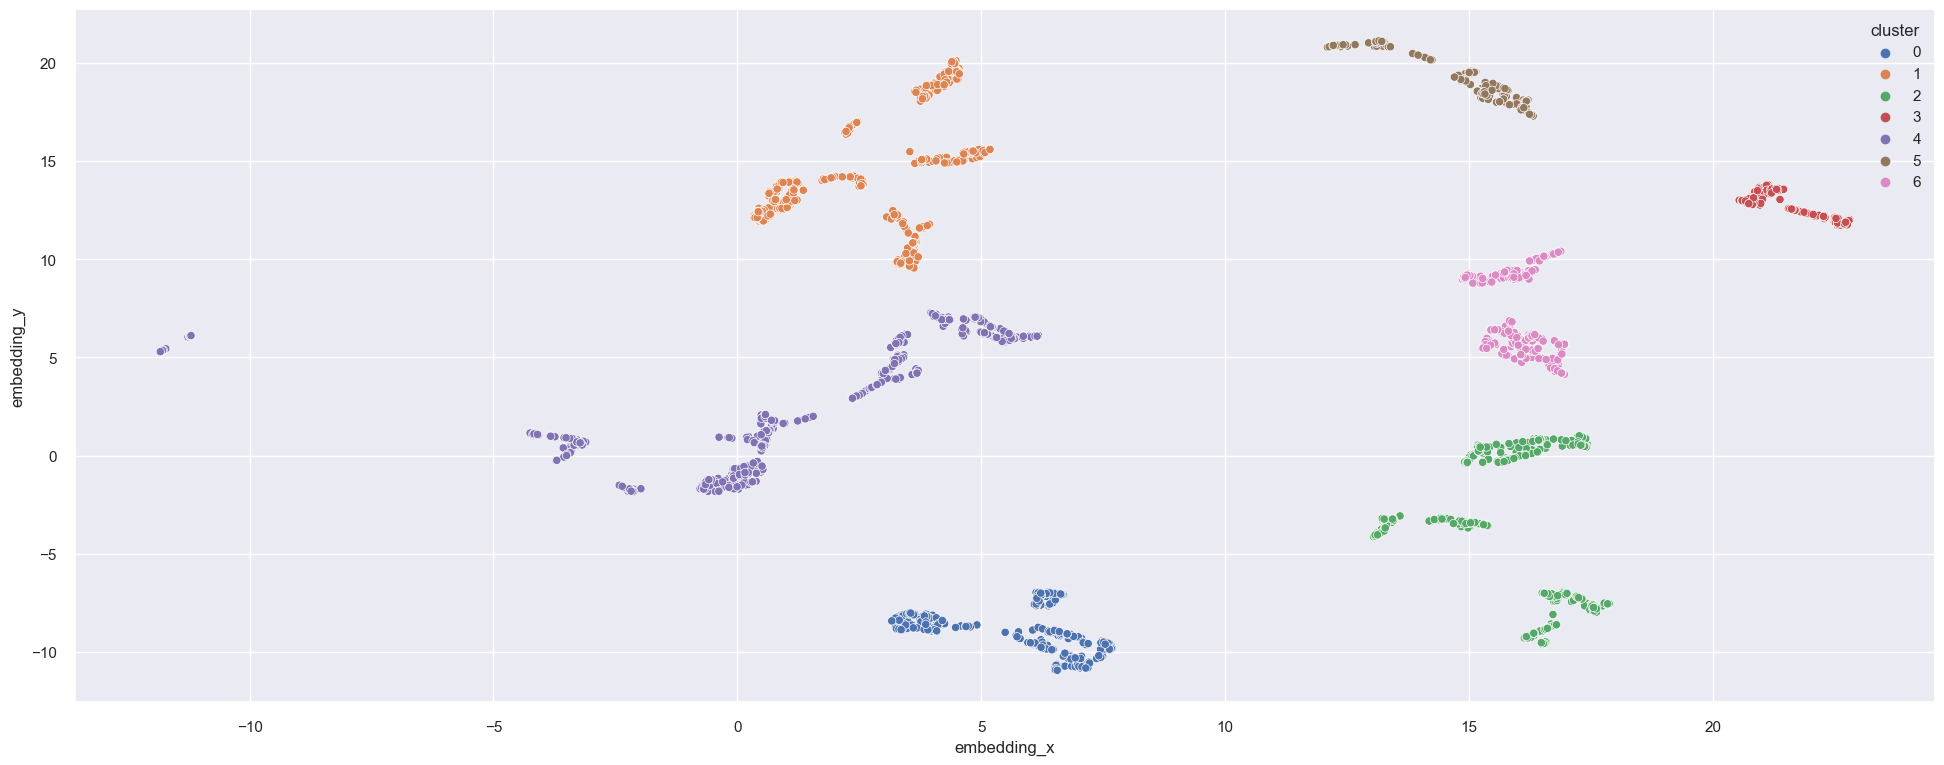

In [149]:
sns.scatterplot( x='embedding_x', y='embedding_y', data=df9, hue='cluster', palette='deep')

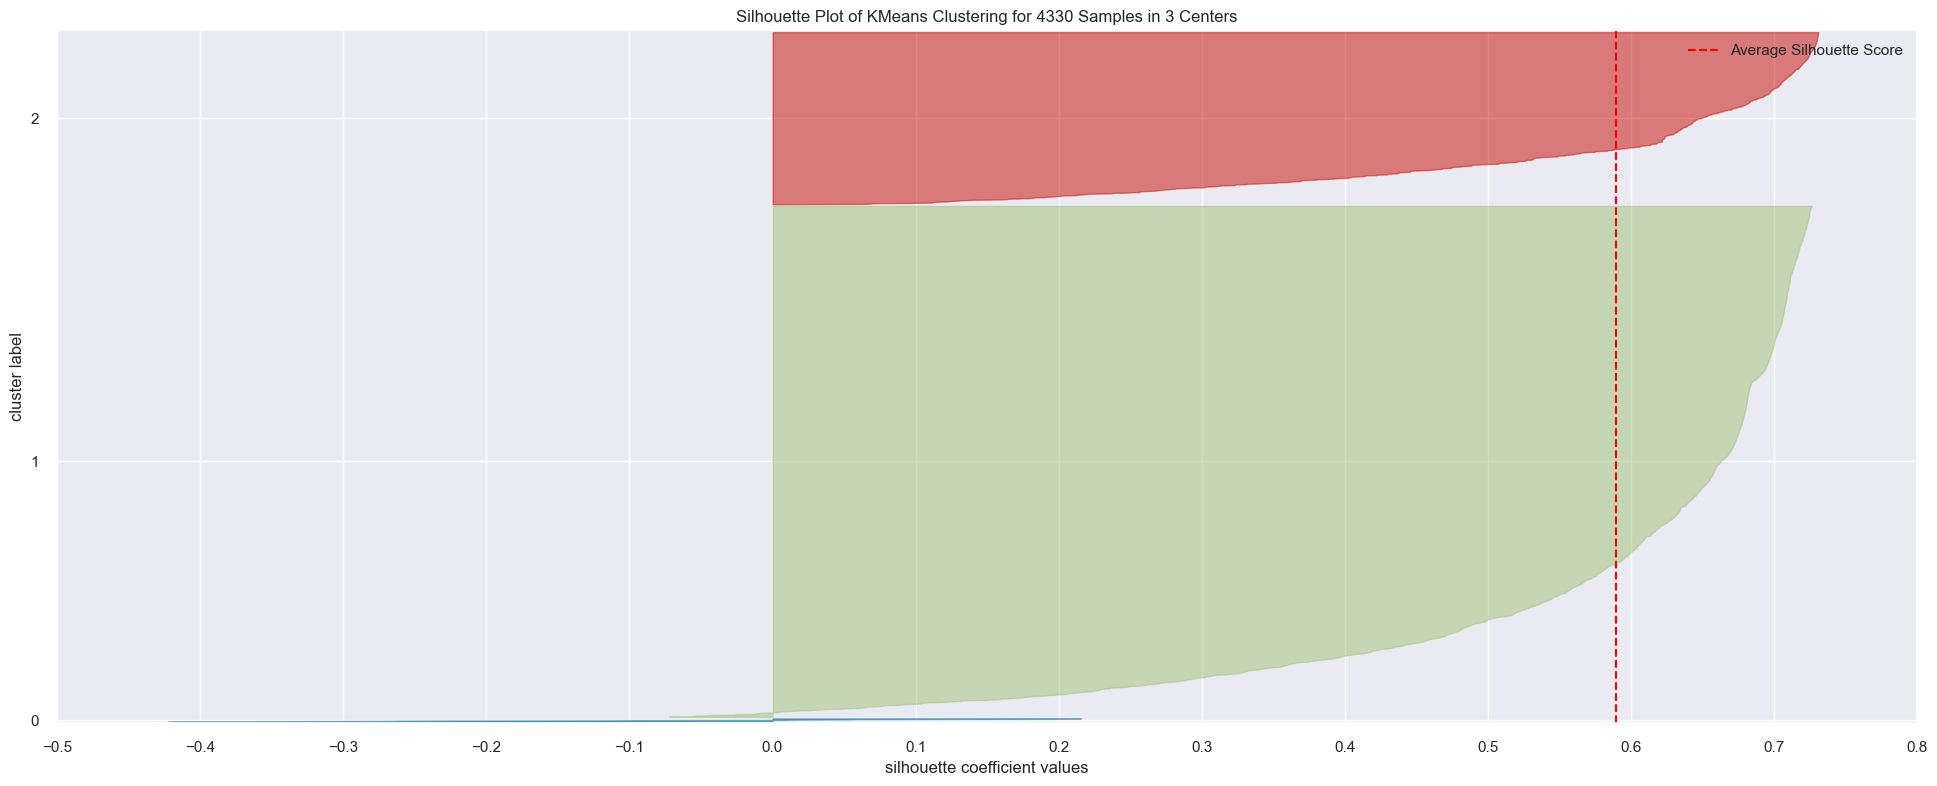

In [49]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit( X )
#visualizer.finalize()

In [ ]:
#fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
#fig.show()

## 9.2. 2d plot

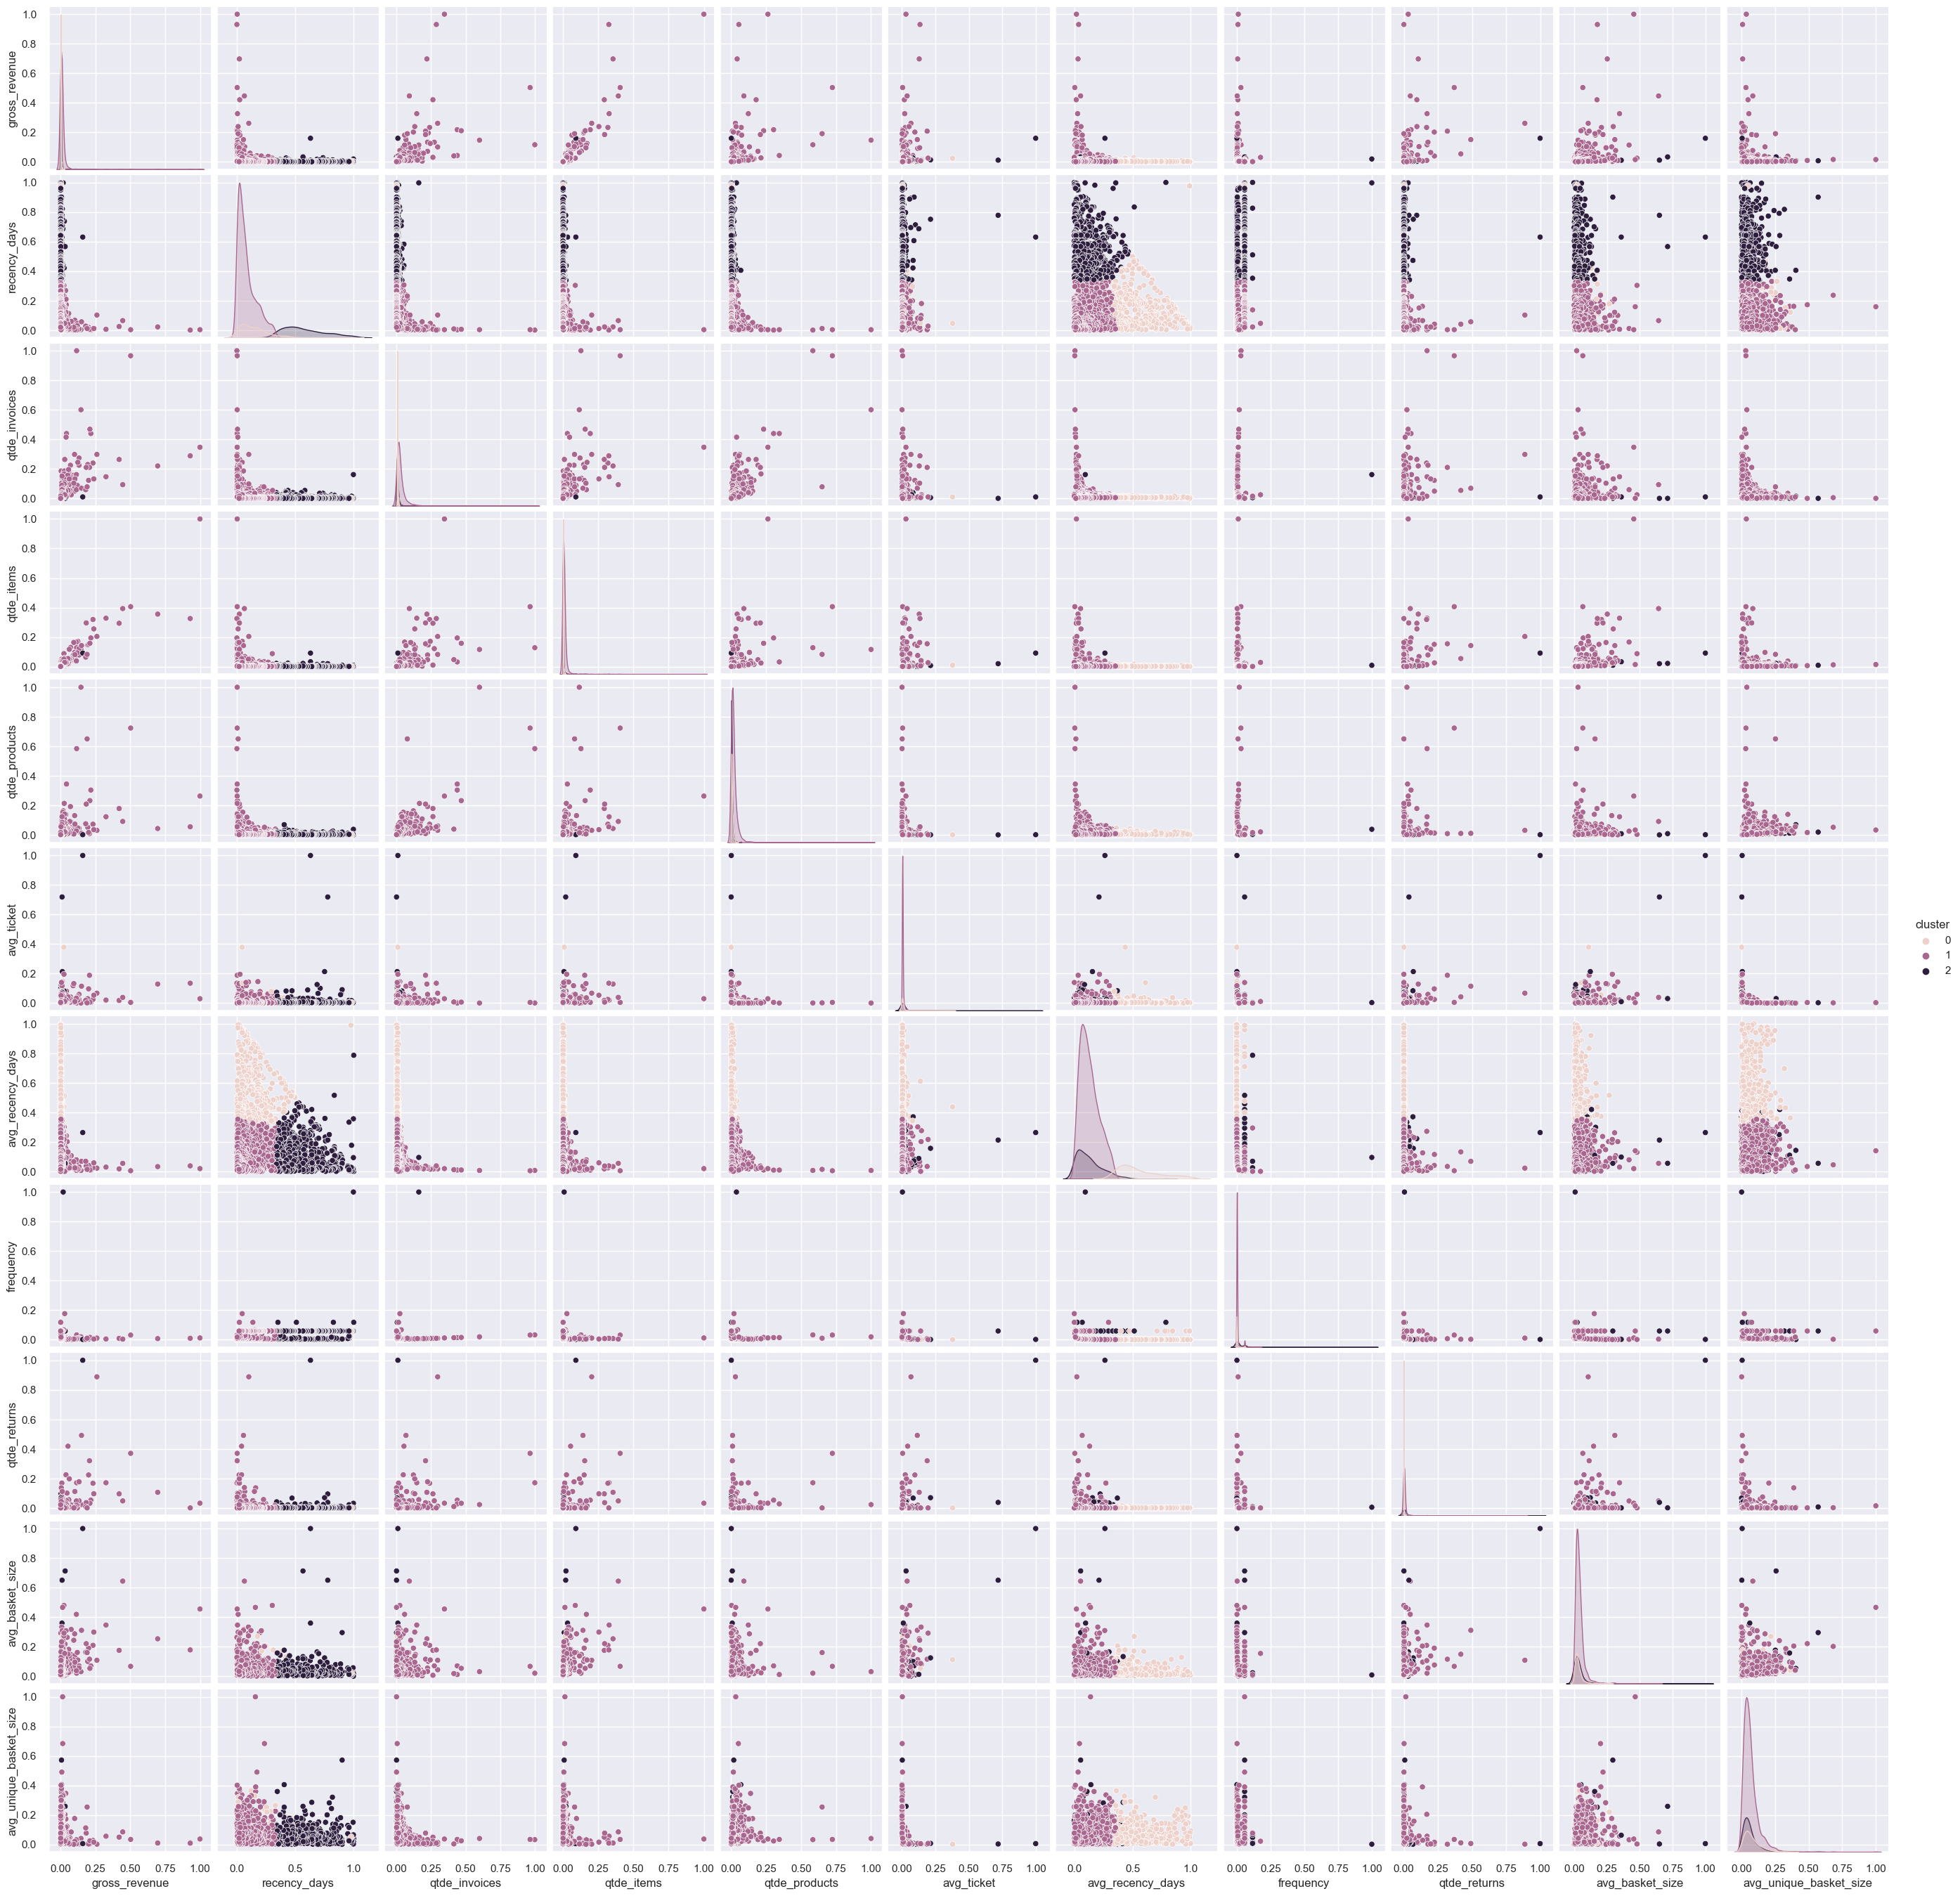

In [67]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP 

In [103]:
df_viz = df9.drop( columns='customer_id', axis=1 )

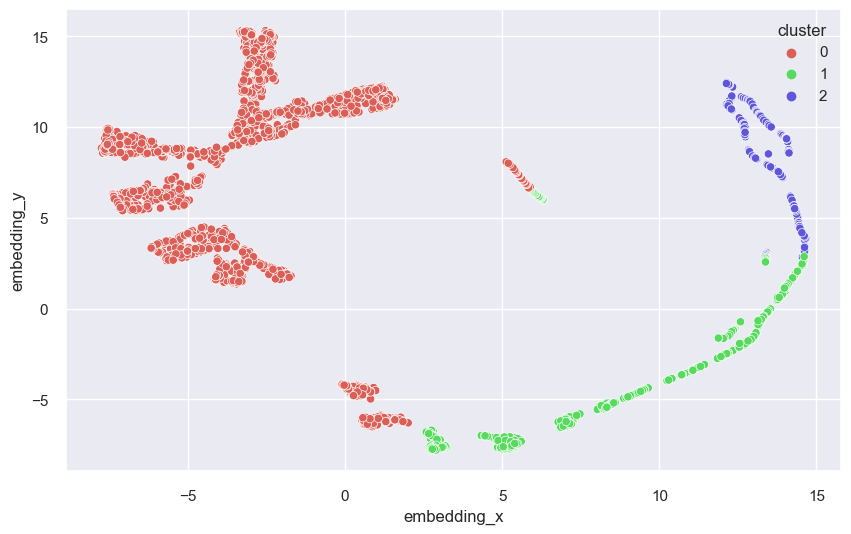

In [104]:
reducer = umap.UMAP( n_neighbors=35, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster',
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )
plt.show()

## 9.2. Cluster Profile

In [105]:
df9.head()

customer_id  gross_revenue  recency_days  qtde_invoices  qtde_items  qtde_products  avg_ticket  avg_recency_days  frequency  qtde_returns  avg_basket_size  avg_unique_basket_size  cluster
0        17850        5391.21         372.0           34.0      1733.0          297.0       18.15         35.500000  17.000000          40.0        50.970588                0.617647        2
1        13047        3232.59          56.0            9.0      1390.0          171.0       18.90         27.250000   0.028302          35.0       154.444444               11.666667        0
2        12583        6705.38           2.0           15.0      5028.0          232.0       28.90         23.187500   0.040323          50.0       335.200000                7.600000        0
3        13748         948.25          95.0            5.0       439.0           28.0       33.87         92.666667   0.017921           0.0        87.800000                4.800000        1
4        15100         876.00         333.0            3.0        80.0            3.0      292.00          8.600000   0.073171          22.0        26.666667                0.333333        2

In [106]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_invoice_no = df9[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Frequency
df_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Returns
df_invoice_no = df9[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

df_cluster

cluster  customer_id  perc_customer  gross_revenue  recency_days  qtde_products  frequency  qtde_returns
0        0         1983      66.812668    3490.523152     21.169945     157.008573   0.063852     41.073122
1        1          652      21.967655    1204.968298    102.593558      61.987730   0.118220      9.656442
2        2          333      11.219677     860.759520    246.252252      37.672673   0.402817     47.462462

In [28]:
!pipreqsnb . 

Traceback (most recent call last):
  File "C:\Users\Luan\anaconda3\envs\pa005insidersclustering\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Luan\anaconda3\envs\pa005insidersclustering\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Luan\anaconda3\envs\pa005insidersclustering\Scripts\pipreqsnb.exe\__main__.py", line 7, in <module>
  File "C:\Users\Luan\anaconda3\envs\pa005insidersclustering\lib\site-packages\pipreqsnb\pipreqsnb.py", line 120, in main
    nb = json.load(open(nb_file, 'r', **open_file_args))
  File "C:\Users\Luan\anaconda3\envs\pa005insidersclustering\lib\json\__init__.py", line 293, in load
    return loads(fp.read(),
  File "C:\Users\Luan\anaconda3\envs\pa005insidersclustering\lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "C:\Users\Luan\anaconda3\envs\pa005insidersclustering\lib\json\decoder.py", line 337, in decode
    obj, end 

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">10.0. Deploy to Production</p></div>         